In [2]:
# !open .

In [3]:
import pandas as pd
import requests
import bs4
import math
import time
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import NeoQuant as nq

## get all company list

In [4]:
companies = nq.get_all_company_list()
companies.index = 'A' + companies.index

## bond spread

In [5]:
# https://www.kisrating.co.kr/ratingsStatistics/statics_spread.do
expected_ratio = 7.91

## load basic dataframe from excel

In [6]:
basic_df = pd.read_excel(r'data/basic_data.xlsx')
basic_df.index = basic_df[basic_df.columns[0]]
basic_df.index.name = ''
basic_df.drop(basic_df.columns[0], axis = 1, inplace = True)

## load fr dataframe from excel

In [7]:
fr_df = pd.read_excel(r'data/fr_data.xlsx')
fr_df.index = fr_df[fr_df.columns[0]]
fr_df.index.name = ''
fr_df.drop(fr_df.columns[0], axis = 1, inplace = True)
big_col = list(fr_df.columns)
small_col = list(fr_df.iloc[0])

new_big_col = []
for num, col in enumerate(big_col):
    if 'Unnamed' in col:
        new_big_col.append(new_big_col[num-1])
    else:
        new_big_col.append(big_col[num])

fr_df.columns = [new_big_col, small_col]
fr_df = fr_df.loc[ fr_df.index.dropna() ]

In [11]:
company_name_list = ['동신건설', '신세계건설', '서희건설', '삼성엔지니어링', 'GS건설', '남화토건',
                    '삼부토건', '대림건설', '한신공영', 'HDC현대산업개발', 'DL', '대우건설', 
                    '동원개발', '우진아이엔에스', '삼호개발', '계룡건설산업', '화성산업', '남광토건',
                    '일성건설', '자이에스앤디', 'KCC건설', '우원개발', '현대건설',
                    '아이에스동서', '동부건설', 'HDC', '서한', '한라',
                    '금호산업', '태영건설', 'DL이앤씨', '웰크론', '한양이엔지',
                    '진흥기업', '티와이홀딩스', '이화공영', '신원종합개발', 'KD'
                    
                    ]

In [12]:
company_code_list = []
for name in company_name_list:
    company_code = nq.get_company_code(name, companies)
    if len(company_code) == 0:
        print('no company code with ' + name)
    company_code_list.append(company_code)
company_code_list

['A025950',
 'A034300',
 'A035890',
 'A028050',
 'A006360',
 'A091590',
 'A001470',
 'A001880',
 'A004960',
 'A294870',
 'A000210',
 'A047040',
 'A013120',
 'A010400',
 'A010960',
 'A013580',
 'A002460',
 'A001260',
 'A013360',
 'A317400',
 'A021320',
 'A046940',
 'A000720',
 'A010780',
 'A005960',
 'A012630',
 'A011370',
 'A014790',
 'A002990',
 'A009410',
 'A375500',
 'A065950',
 'A045100',
 'A002780',
 'A363280',
 'A001840',
 'A017000',
 'A044180']

In [13]:
sector_df = basic_df.loc[company_code_list]

## calculate adequate price

In [15]:
total = len(sector_df)

for num, code in enumerate(sector_df.index):
    company_name = nq.get_company_name(code, companies)
    print(str(num + 1) + ' / ' + str(total) + " : " + company_name + ' (' + str(code) + ')')

#     print(num, code, company_name)
    for col in reversed(fr_df.columns.levels[0]):
#         print(fr_df[col]['ROE'])
        try:
            roe = pd.to_numeric(fr_df.loc[code][col]['ROE'])
            per = pd.to_numeric(fr_df.loc[code][col]['PER'])
            pbr = pd.to_numeric(fr_df.loc[code][col]['PBR'])
            asset = pd.to_numeric(fr_df.loc[code][col]['지배주주지분']) * 100000000
            debt_rate = pd.to_numeric(fr_df.loc[code][col]['부채비율'])
            keep_rate = pd.to_numeric(fr_df.loc[code][col]['유보율'])
            interest_rate = pd.to_numeric(fr_df.loc[code][col]['배당수익률'])

                
            if not math.isnan(roe) and not math.isnan(asset):
                print('standard date : ' + col)
                stock_count = sector_df.loc[code]['주식수']
                sector_df.at[code, '기준일'] = col
                sector_df.at[code, 'roe'] = roe
                sector_df.at[code, 'per'] = per
                sector_df.at[code, 'pbr'] = pbr
                sector_df.at[code, '부채비율'] = debt_rate
                sector_df.at[code, '유보율'] = keep_rate
                sector_df.at[code, '배당수익률'] = interest_rate
                
                sector_df.at[code, 'expectation'] = expected_ratio
    #             print('stock_count : ' + str(stock_count))
                high = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 1)
    #             print('high : ' + str(high))
                sector_df.at[code, 'high'] = high
                middle = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.9)
                sector_df.at[code, 'middle'] = middle
                low = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.8)
                sector_df.at[code, 'low'] = low
                very_low = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.5)
                sector_df.at[code, 'very_low'] = very_low
                break
        except ValueError:
            print('>>> ValueError')
            continue
        except KeyError:
            print('>>> KeyError')
            continue


sector_df['dis_rate'] = sector_df['price'] / sector_df['low']
sector_df = sector_df.sort_values(by='dis_rate', ascending=True)
sector_df['rank'] = sector_df['dis_rate'].rank()

1 / 38 : 동신건설 (A025950)
standard date : 2019/12
2 / 38 : 신세계건설 (A034300)
standard date : 2019/12
3 / 38 : 서희건설 (A035890)
standard date : 2019/12
4 / 38 : 삼성엔지니어링 (A028050)
standard date : 2019/12
5 / 38 : GS건설 (A006360)
standard date : 2019/12
6 / 38 : 남화토건 (A091590)
standard date : 2019/12
7 / 38 : 삼부토건 (A001470)
standard date : 2019/12
8 / 38 : 대림건설 (A001880)
standard date : 2019/12
9 / 38 : 한신공영 (A004960)
standard date : 2019/12
10 / 38 : HDC현대산업개발 (A294870)
standard date : 2019/12
11 / 38 : DL (A000210)
standard date : 2019/12
12 / 38 : 대우건설 (A047040)
standard date : 2019/12
13 / 38 : 동원개발 (A013120)
standard date : 2019/12
14 / 38 : 우진아이엔에스 (A010400)
standard date : 2019/12
15 / 38 : 삼호개발 (A010960)
standard date : 2019/12
16 / 38 : 계룡건설산업 (A013580)
standard date : 2019/12
17 / 38 : 화성산업 (A002460)
standard date : 2019/12
18 / 38 : 남광토건 (A001260)
standard date : 2019/12
19 / 38 : 일성건설 (A013360)
standard date : 2019/12
20 / 38 : 자이에스앤디 (A317400)
standard date : 2019/12
21 / 38 : KCC건설

In [16]:
sector_df.to_excel(r'data/construct_sector.xlsx')

In [17]:
sector_df = pd.read_excel(r'data/construct_sector.xlsx')
sector_df.index = sector_df[sector_df.columns[0]]
sector_df.index.name = ''
sector_df.drop(sector_df.columns[0], axis = 1, inplace = True)

## 수익률 계산

In [18]:
port_df = sector_df

In [19]:
import time

port_list = port_df.index
total = len(port_list)
for num, company_code in enumerate(port_list):
    company_name = nq.get_company_name(company_code, companies)
    print(str(num + 1) + ' / ' + str(total) + " : " + company_name + ' (' + str(company_code) + ')')
    time.sleep(1)
    try:
        price_df = nq.request_price_list(company_code, 'day', 100)
    except requests.exceptions.Timeout:
        time.sleep(60)
        price_df = nq.request_price_list(company_code, 'day', 100)
        
    current = price_df[price_df.columns[0]][-1]
    port_df.at[company_code, 'current'] = int(current)

1 / 38 : KD (A044180)
2 / 38 : DL (A000210)
3 / 38 : HDC (A012630)
4 / 38 : 한신공영 (A004960)
5 / 38 : 태영건설 (A009410)
6 / 38 : 계룡건설산업 (A013580)
7 / 38 : 화성산업 (A002460)
8 / 38 : KCC건설 (A021320)
9 / 38 : 삼호개발 (A010960)
10 / 38 : 신원종합개발 (A017000)
11 / 38 : 동원개발 (A013120)
12 / 38 : 동부건설 (A005960)
13 / 38 : HDC현대산업개발 (A294870)
14 / 38 : 서한 (A011370)
15 / 38 : 우진아이엔에스 (A010400)
16 / 38 : 서희건설 (A035890)
17 / 38 : GS건설 (A006360)
18 / 38 : 현대건설 (A000720)
19 / 38 : 한양이엔지 (A045100)
20 / 38 : 우원개발 (A046940)
21 / 38 : 일성건설 (A013360)
22 / 38 : 신세계건설 (A034300)
23 / 38 : 금호산업 (A002990)
24 / 38 : 대우건설 (A047040)
25 / 38 : 대림건설 (A001880)
26 / 38 : 삼성엔지니어링 (A028050)
27 / 38 : 한라 (A014790)
28 / 38 : 남화토건 (A091590)
29 / 38 : 아이에스동서 (A010780)
30 / 38 : 자이에스앤디 (A317400)
31 / 38 : 진흥기업 (A002780)
32 / 38 : 삼부토건 (A001470)
33 / 38 : 남광토건 (A001260)
34 / 38 : 웰크론 (A065950)
35 / 38 : 이화공영 (A001840)
36 / 38 : 동신건설 (A025950)
37 / 38 : DL이앤씨 (A375500)
38 / 38 : 티와이홀딩스 (A363280)


In [20]:
profit_rate = (port_df['current'] - port_df['price']) / port_df['price']
profit_rate = profit_rate.dropna()
profit_rate = profit_rate.map(lambda rate: str("%.2f" % round(float(rate * 100), 2)) + '%')
port_df['수익률'] = profit_rate

In [21]:
profit_rate = port_df['수익률'].map(lambda rate: float(rate[:-1]))
average_profit = profit_rate.sum() / len(port_df)
print('average profit : ' + "%.2f" % average_profit + '%')

average profit : 0.00%


In [25]:
port_df.to_excel(r'data/construct_sector_profit.xlsx')

## show chart

In [23]:
company_code_list = port_df.index

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


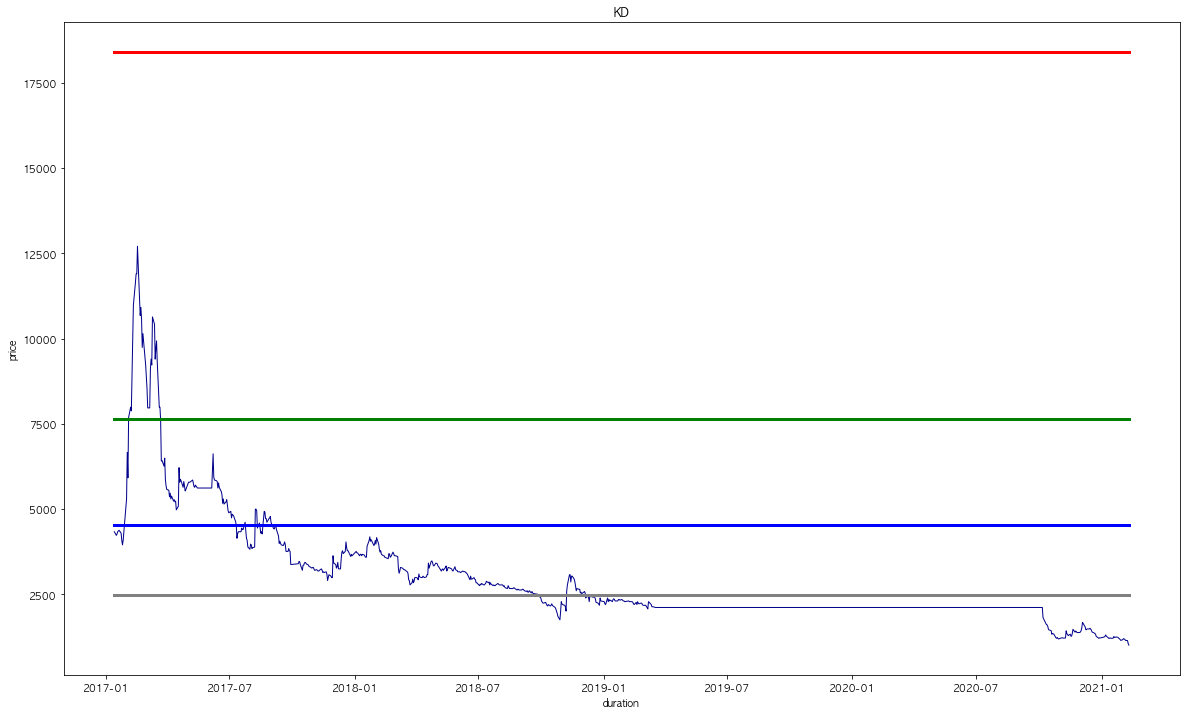

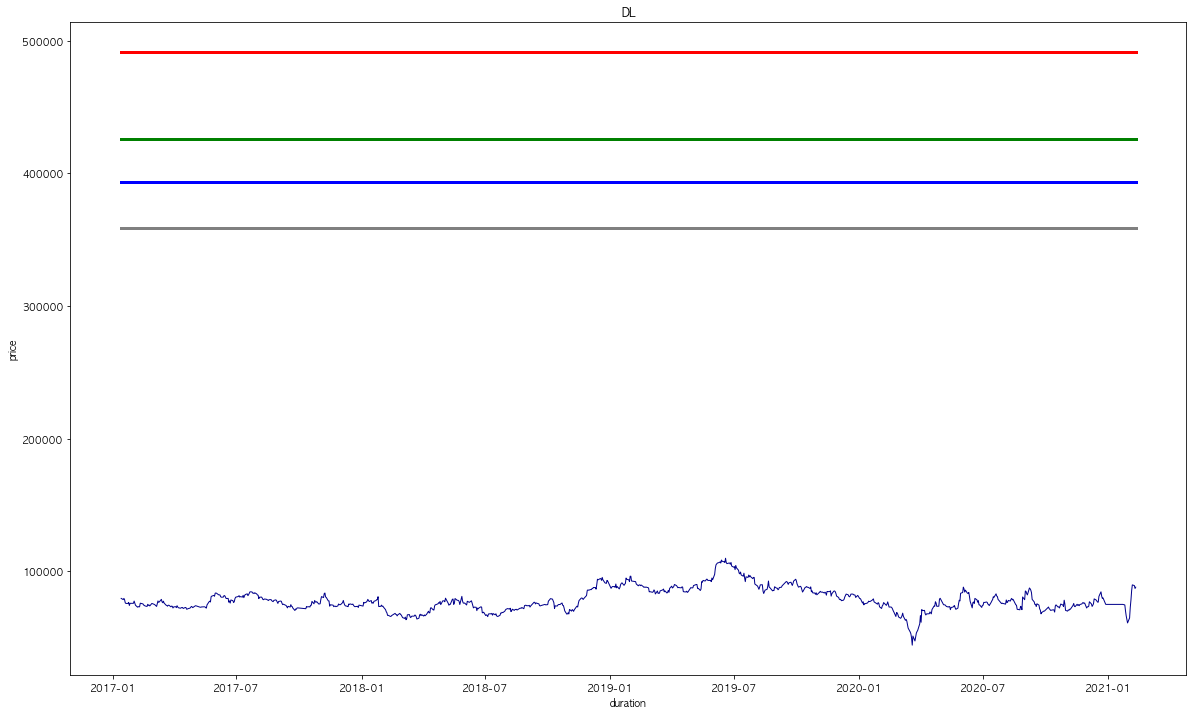

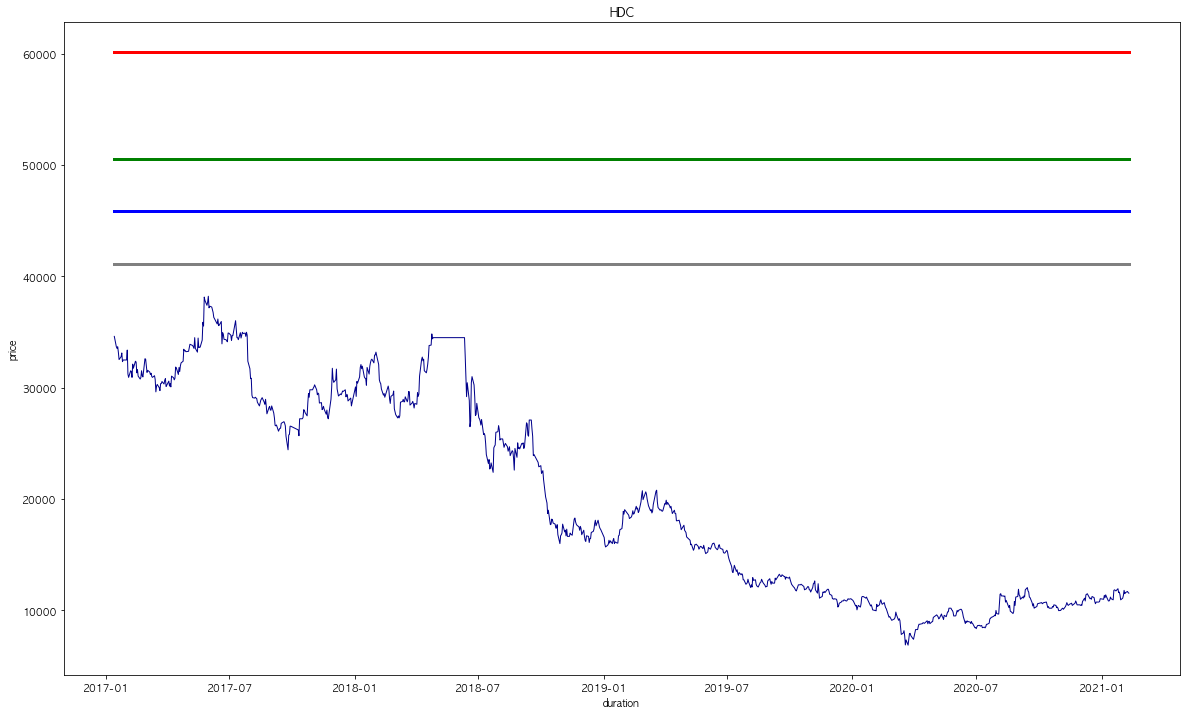

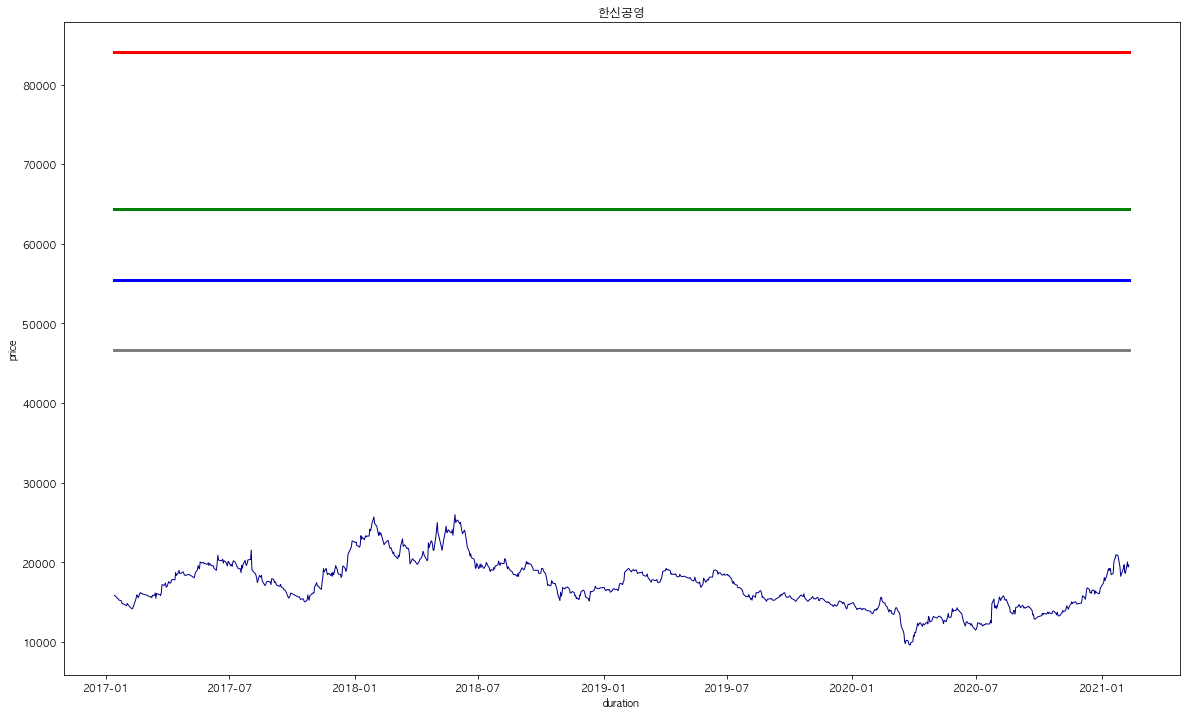

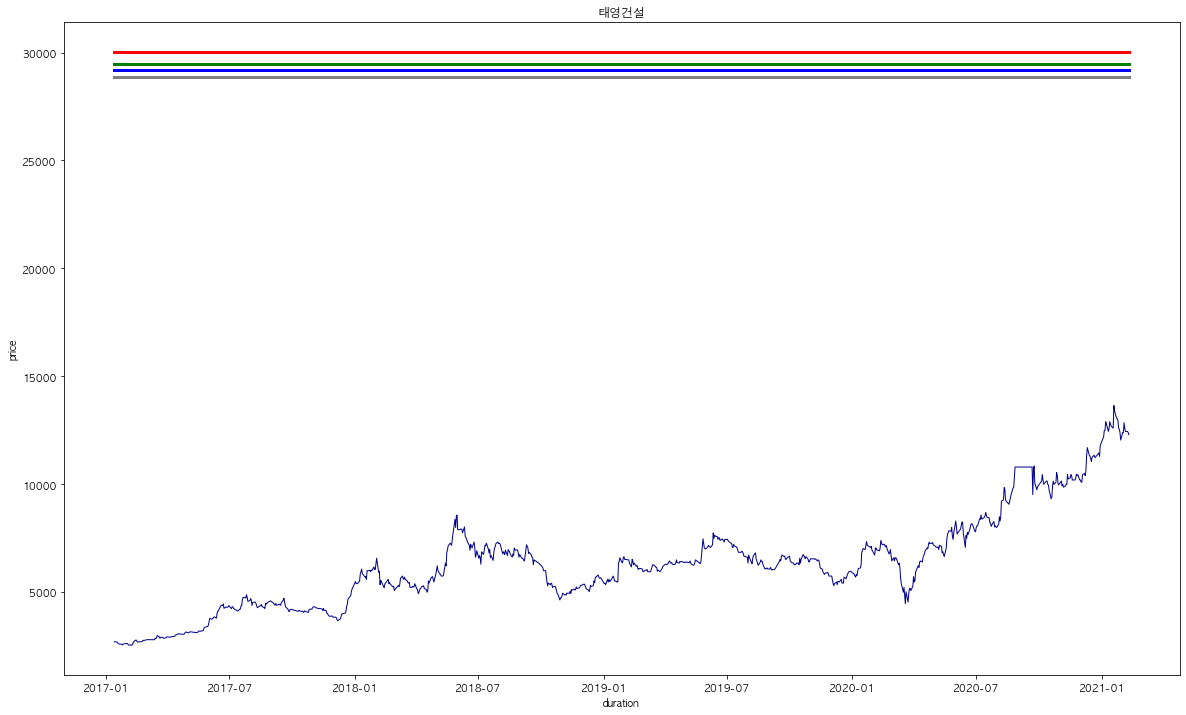

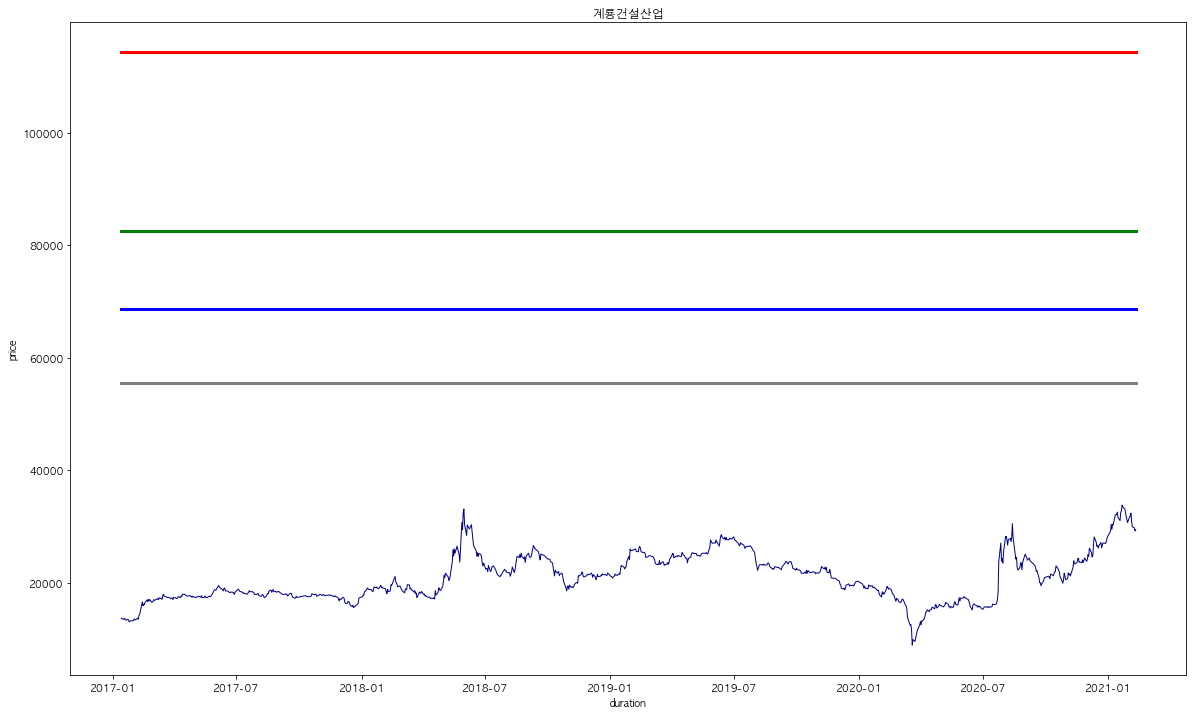

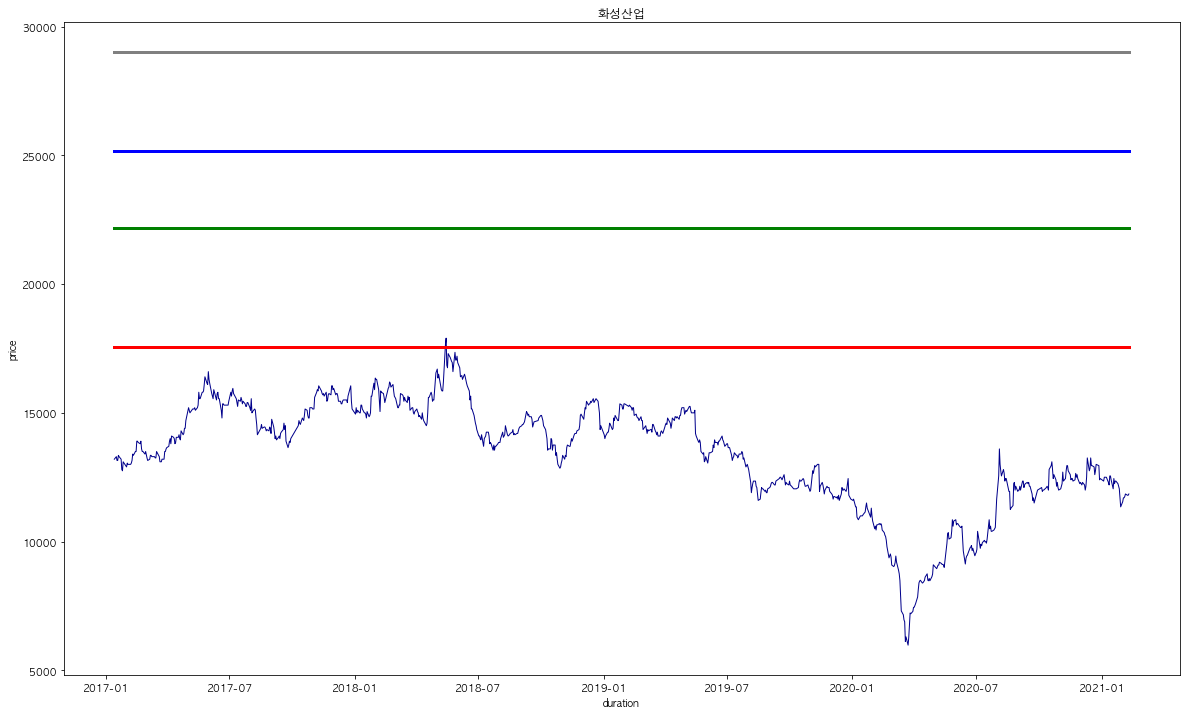

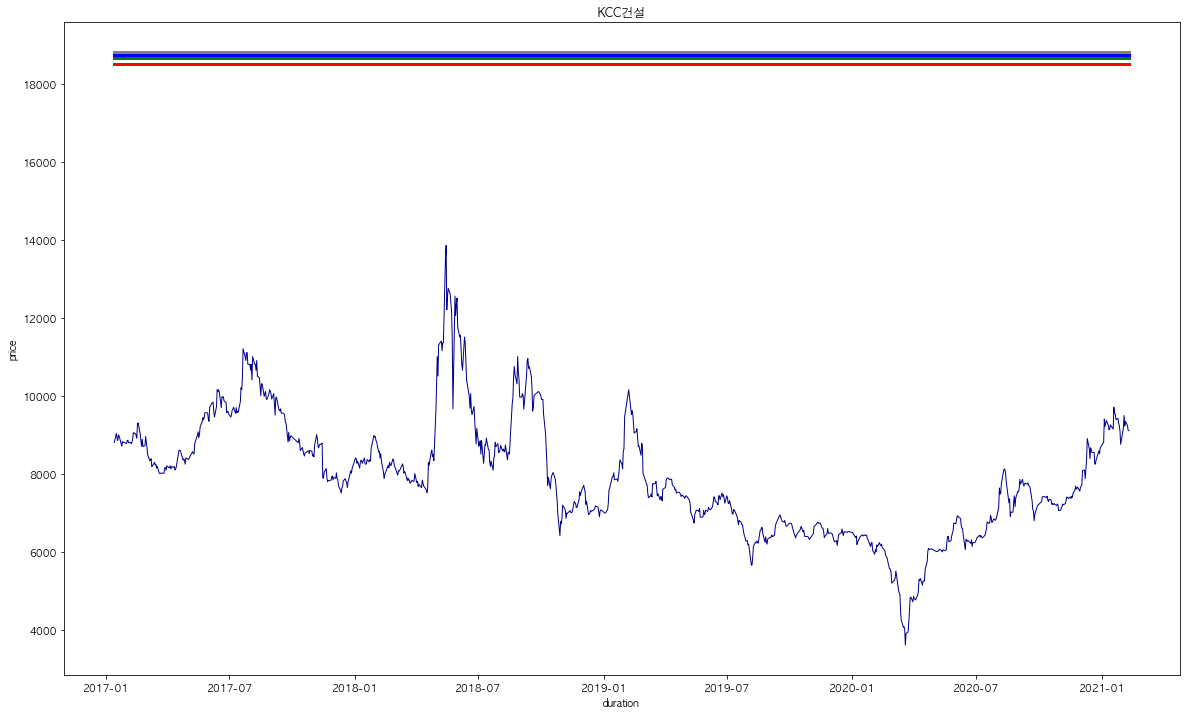

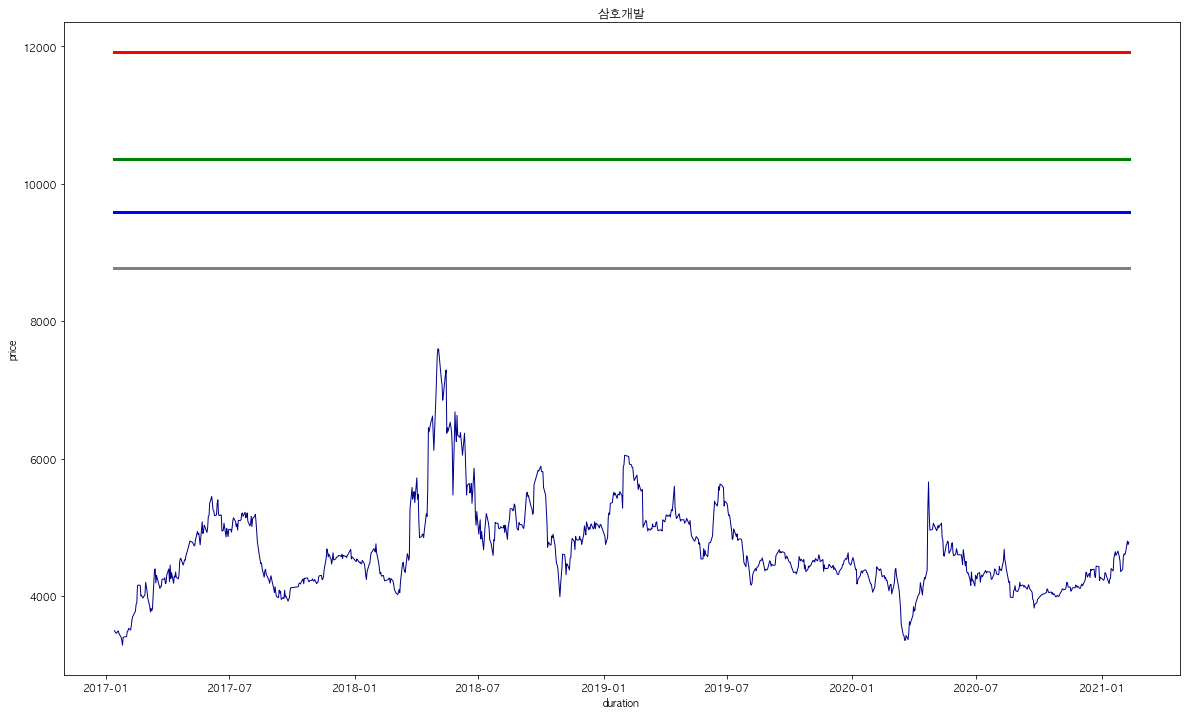

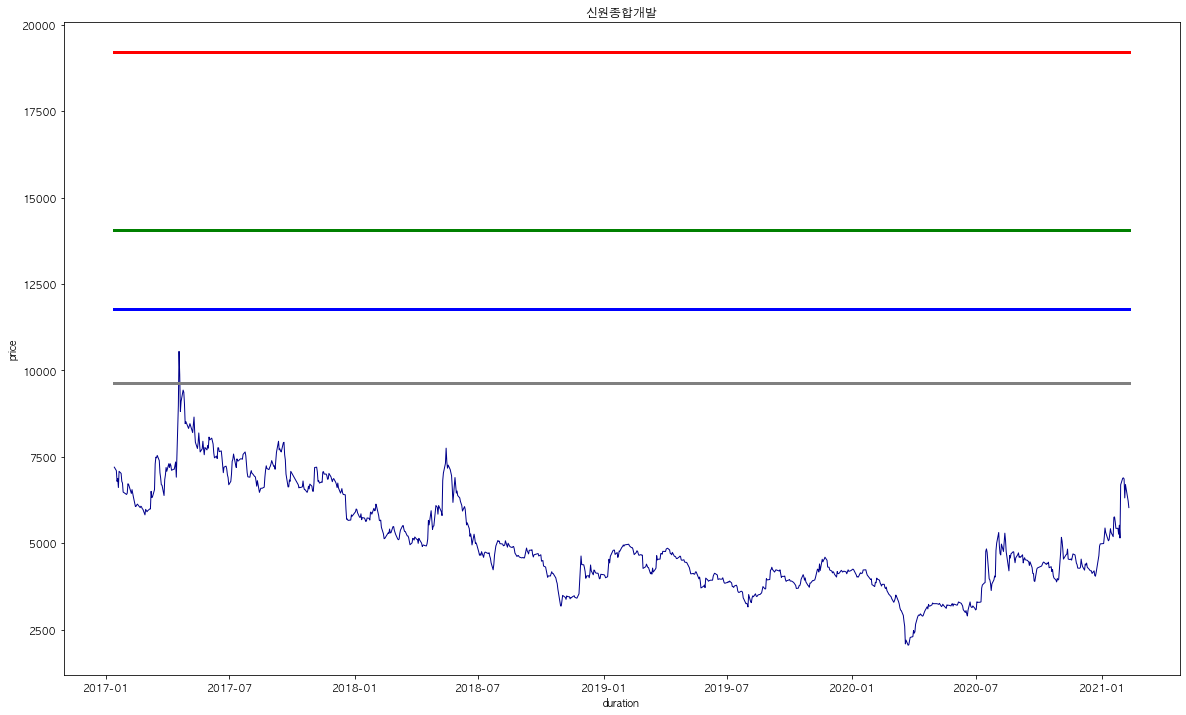

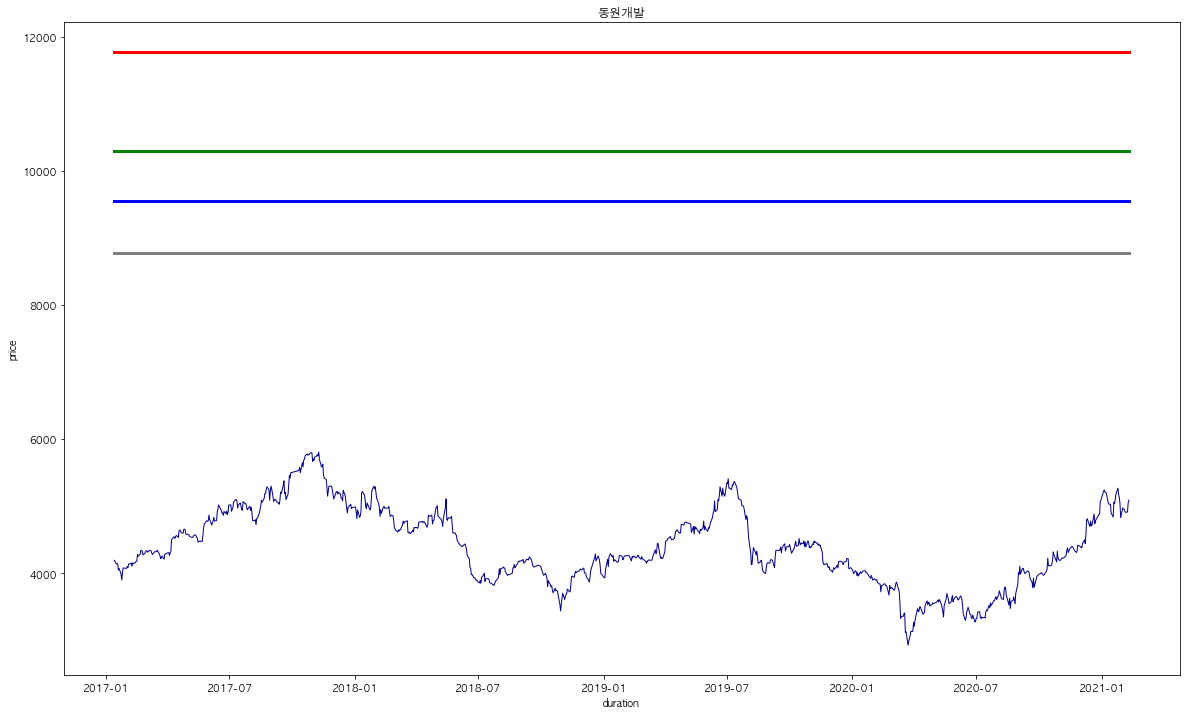

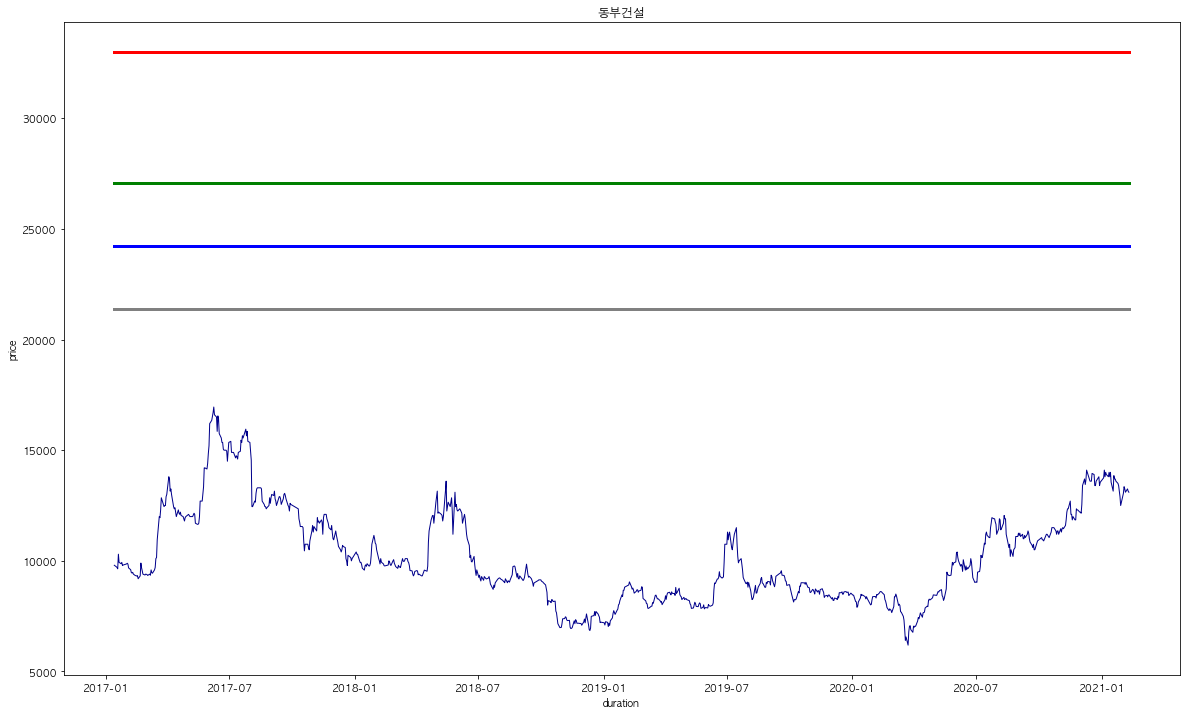

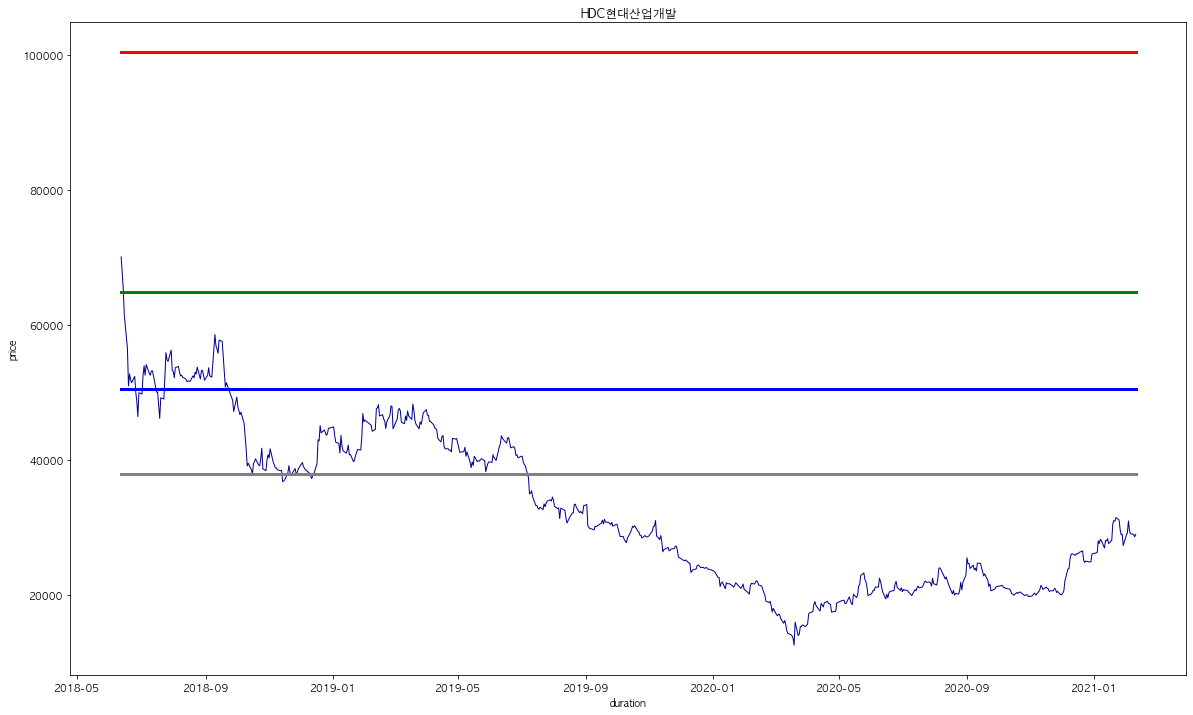

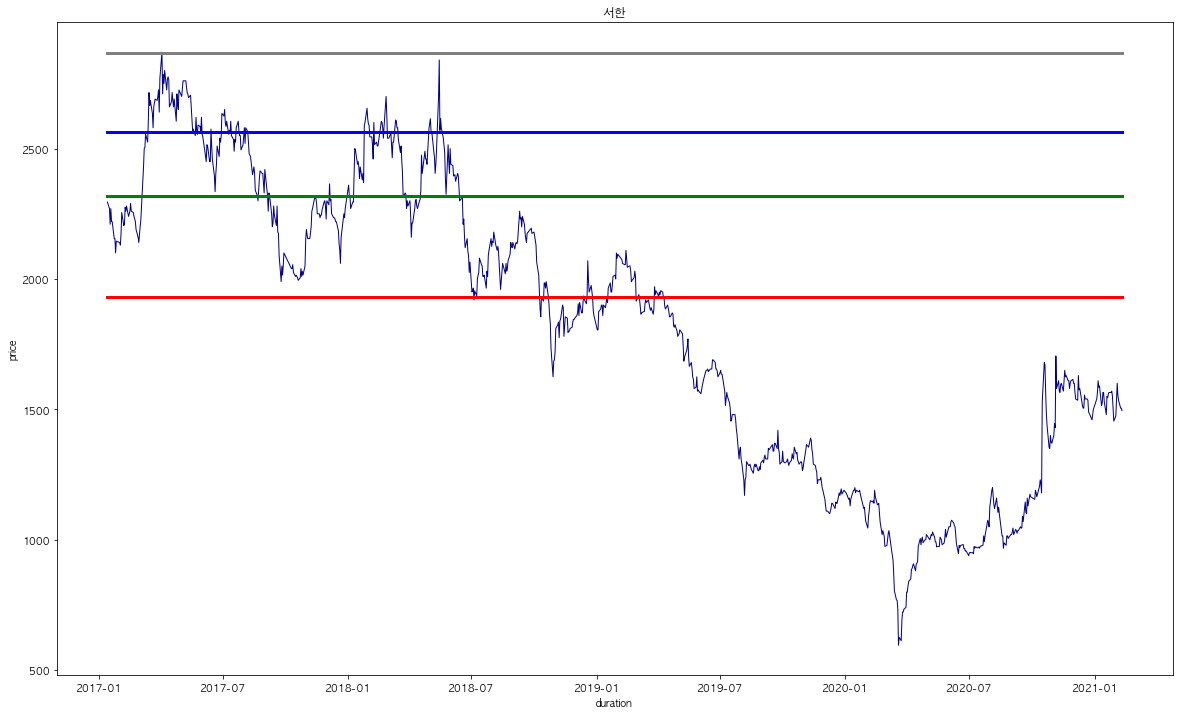

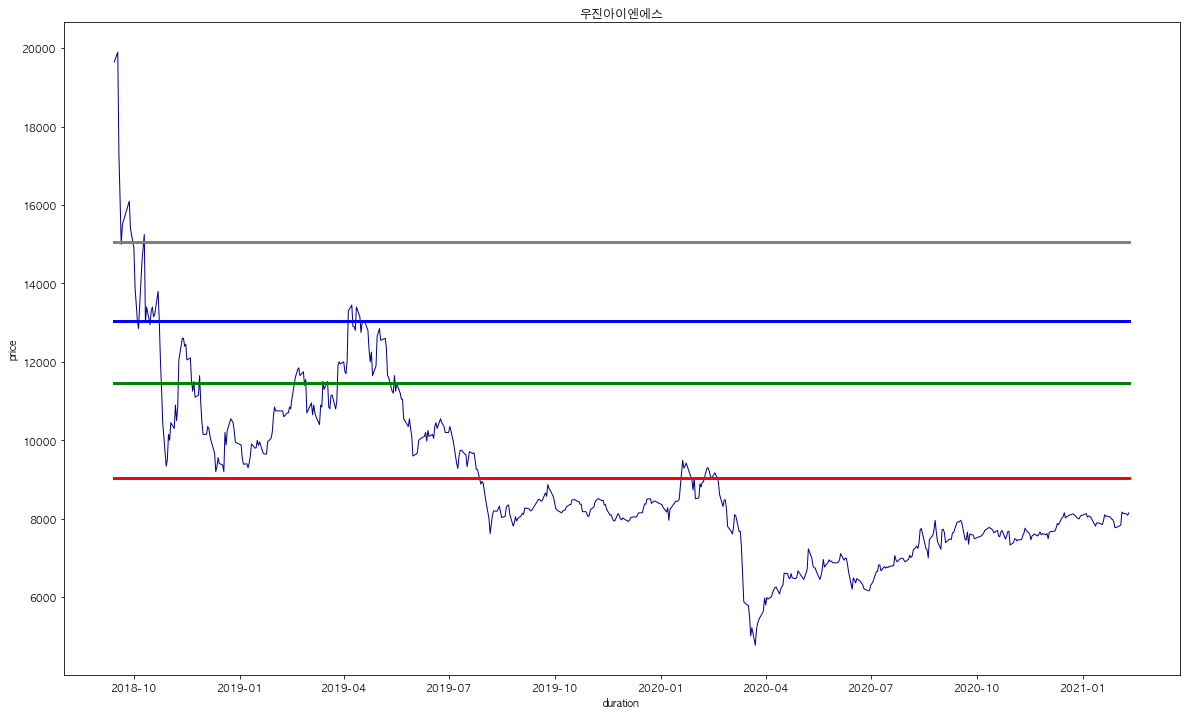

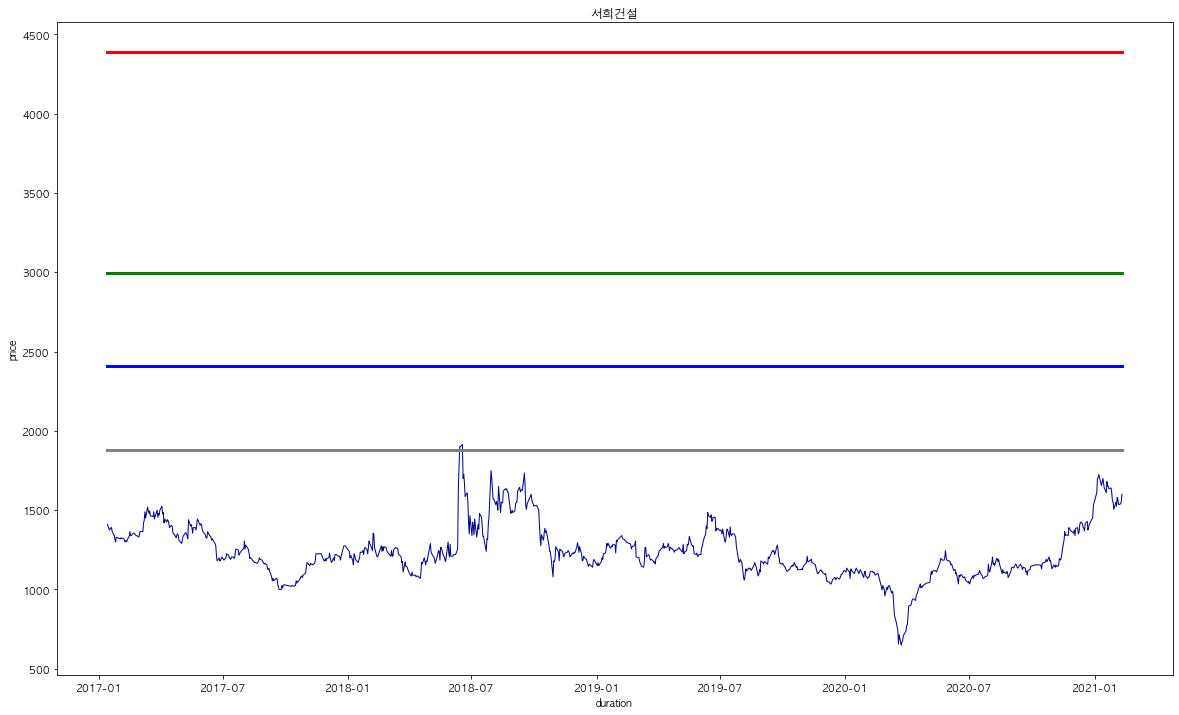

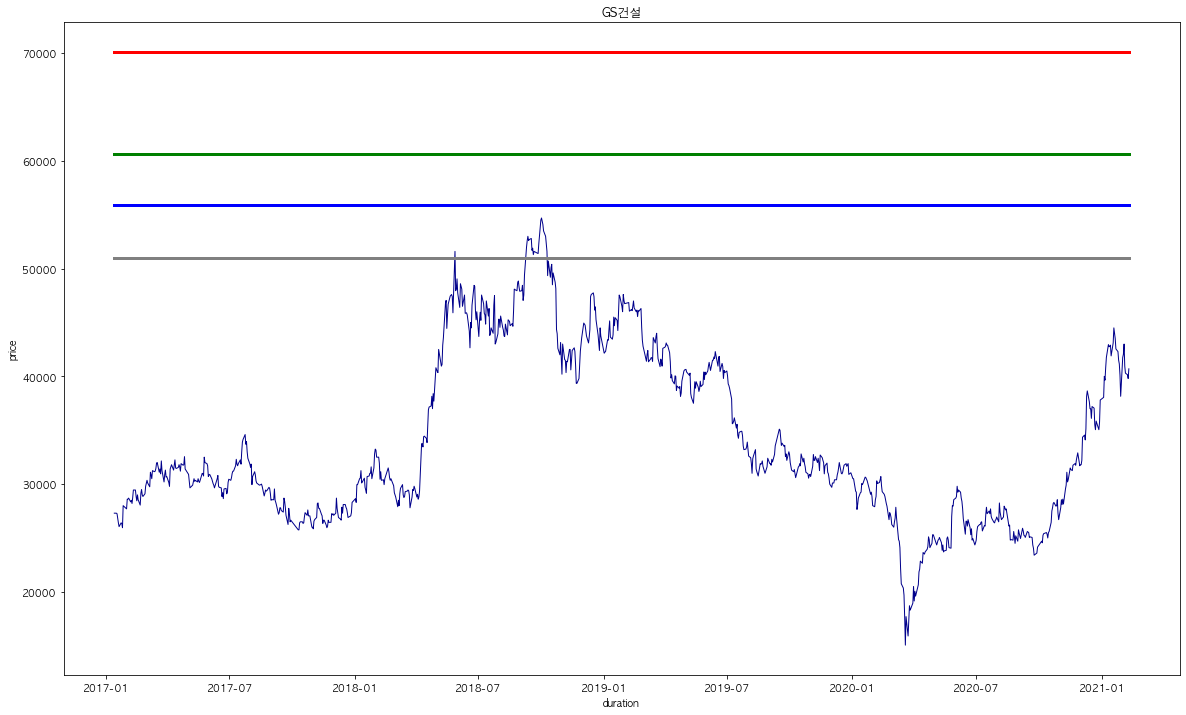

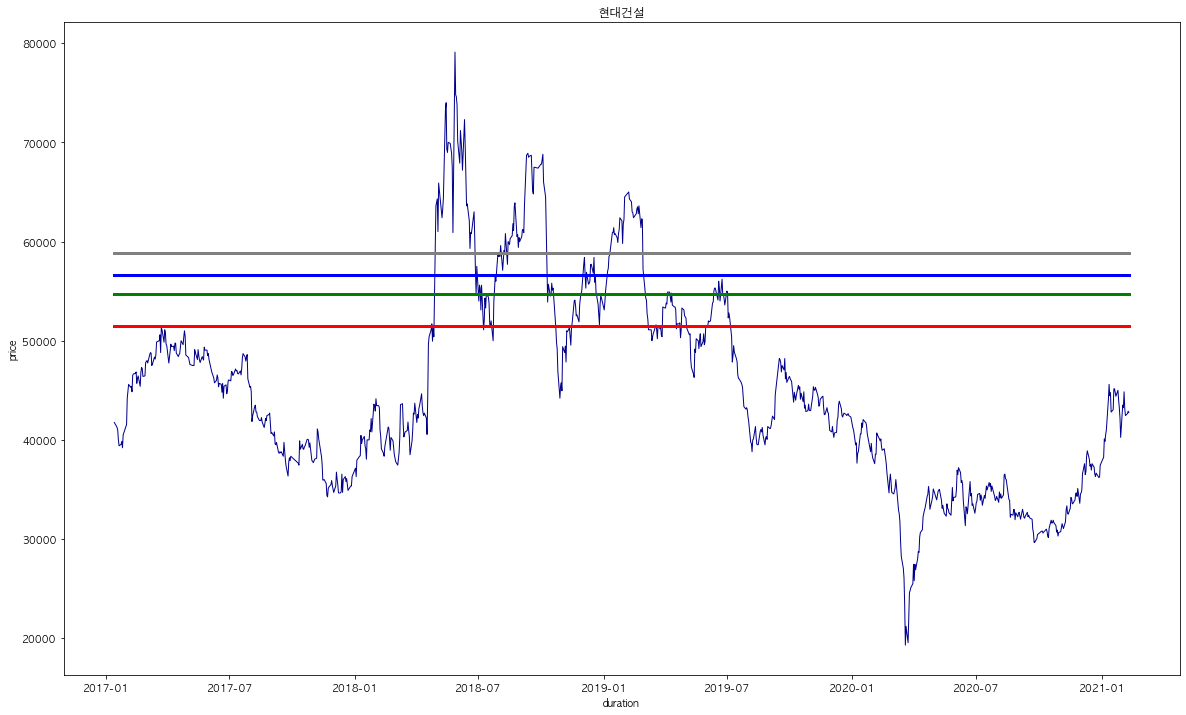

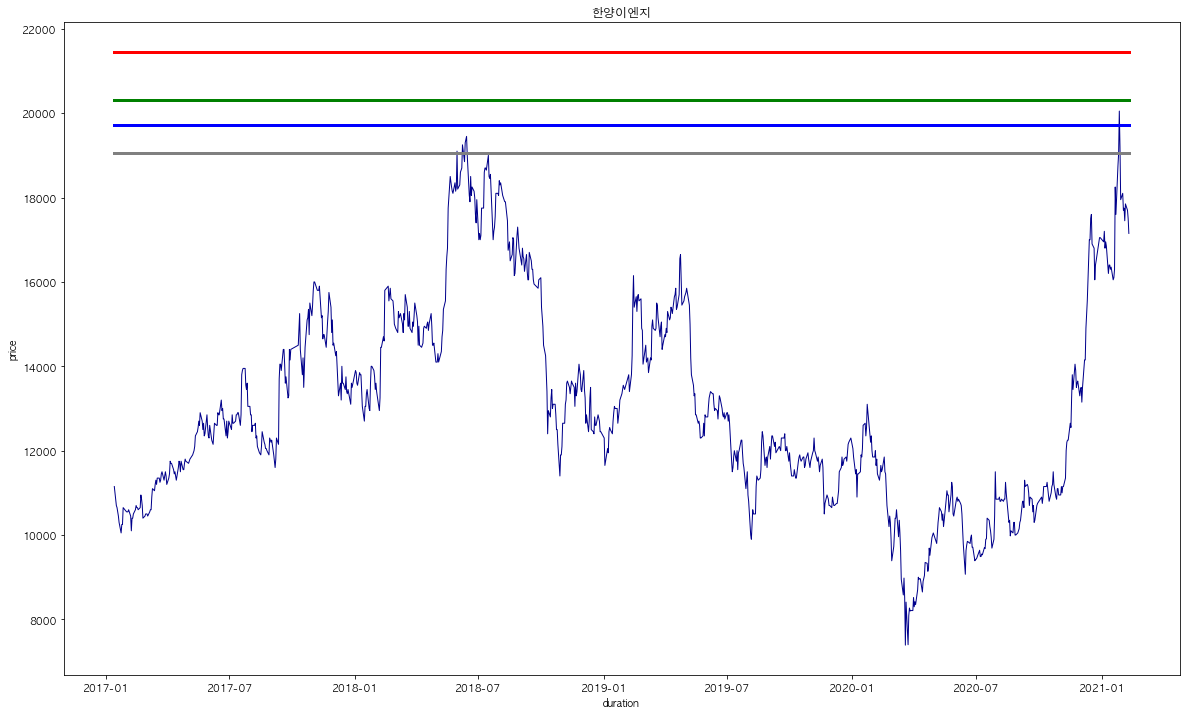

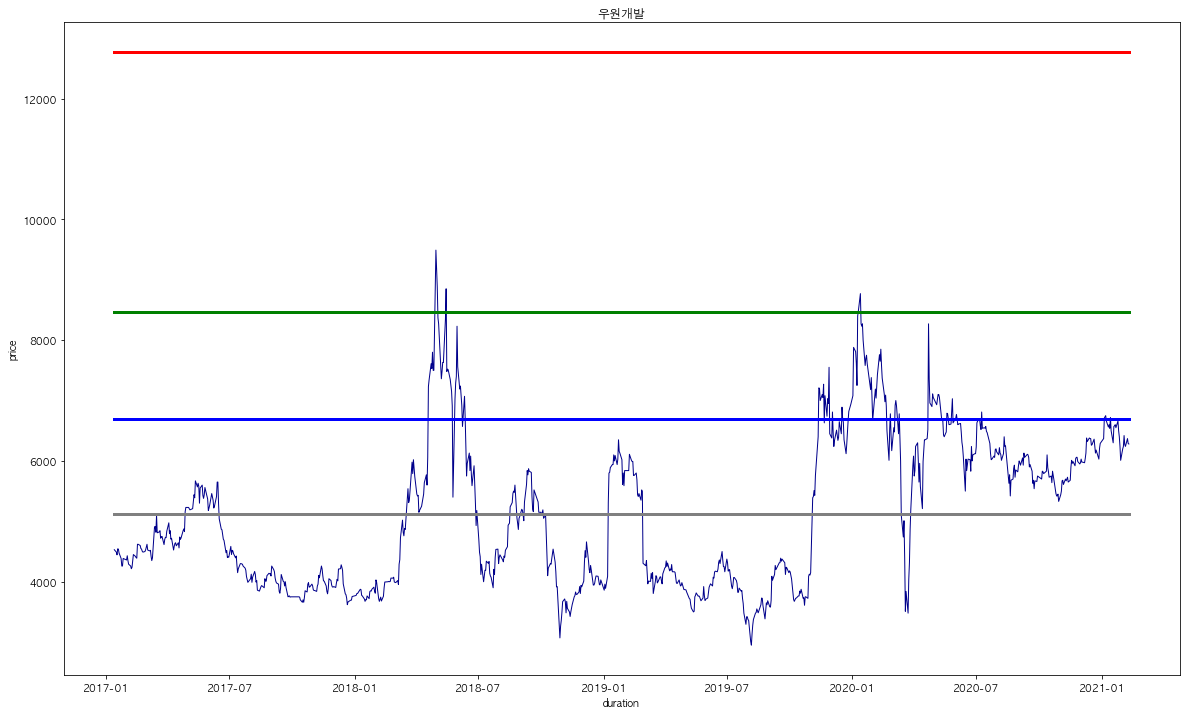

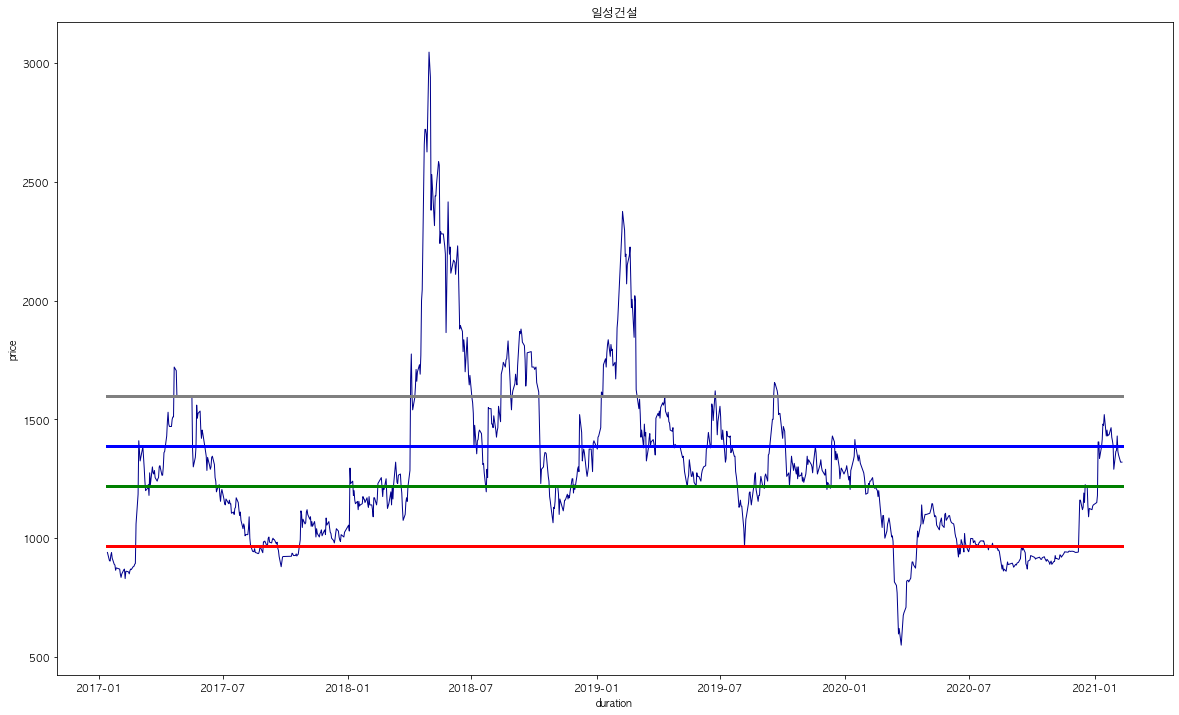

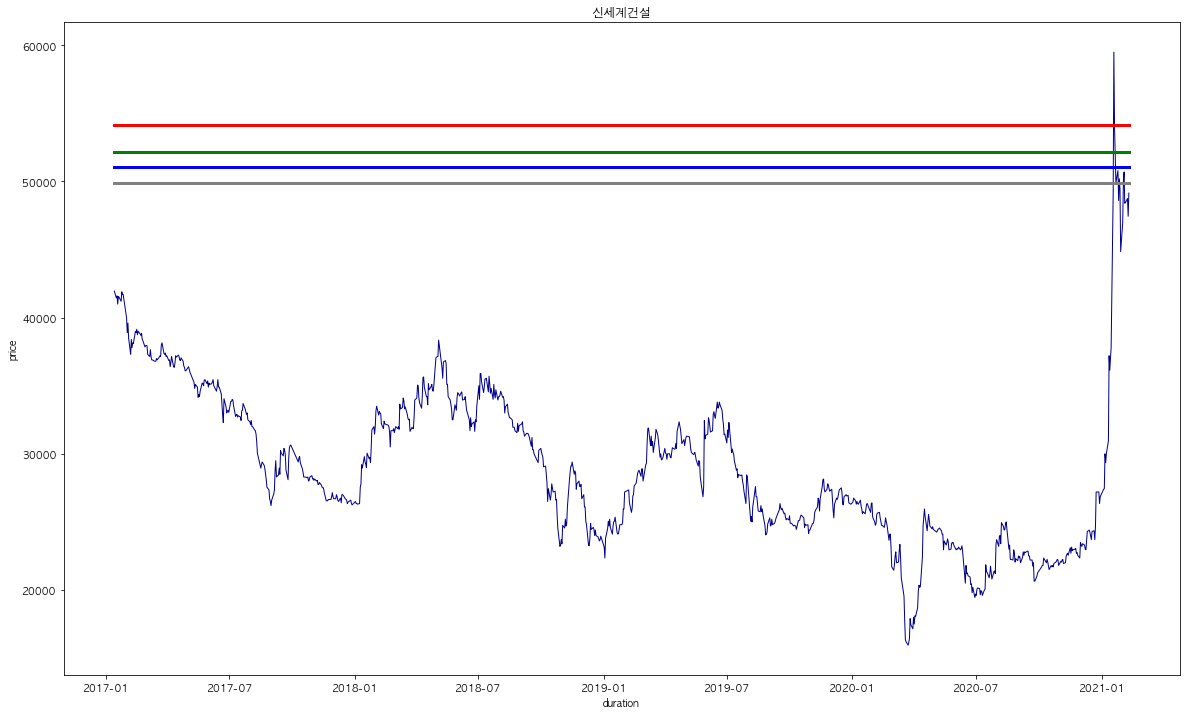

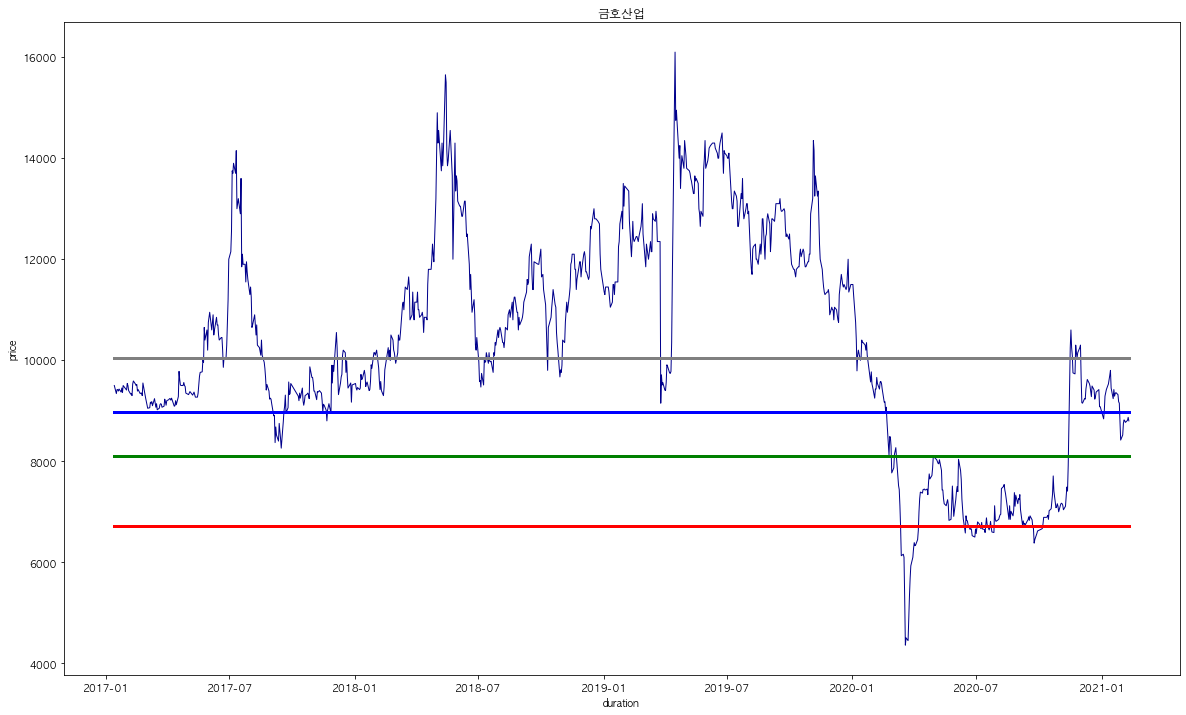

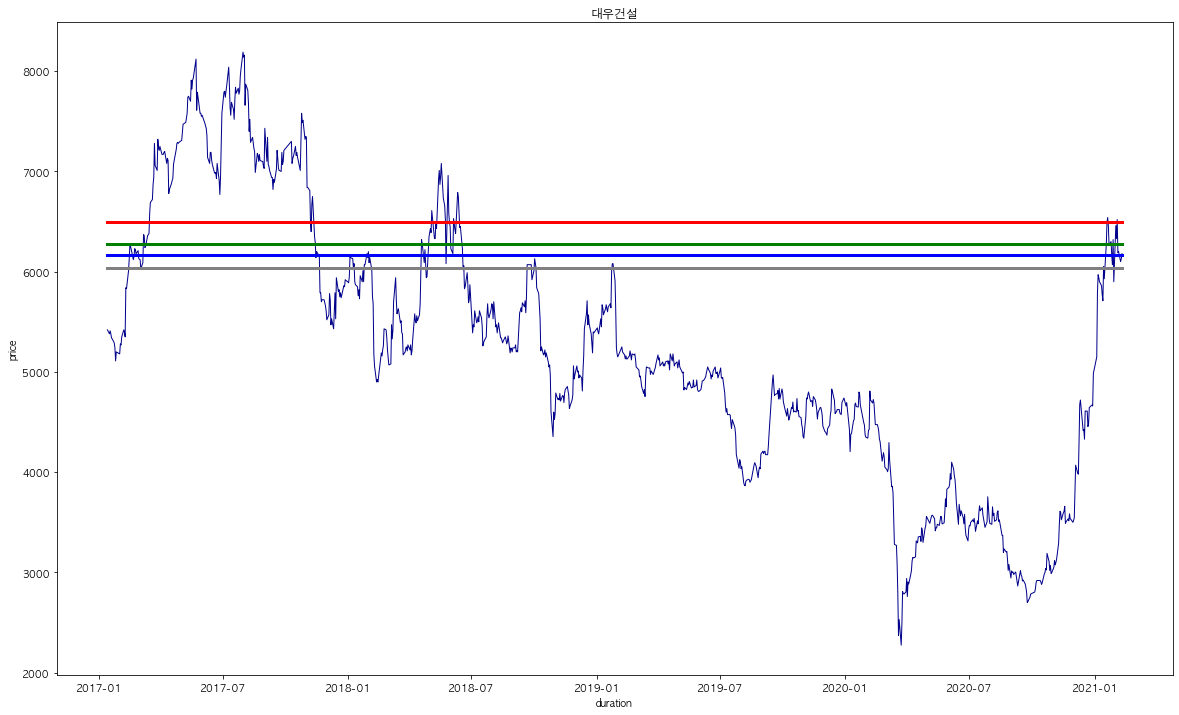

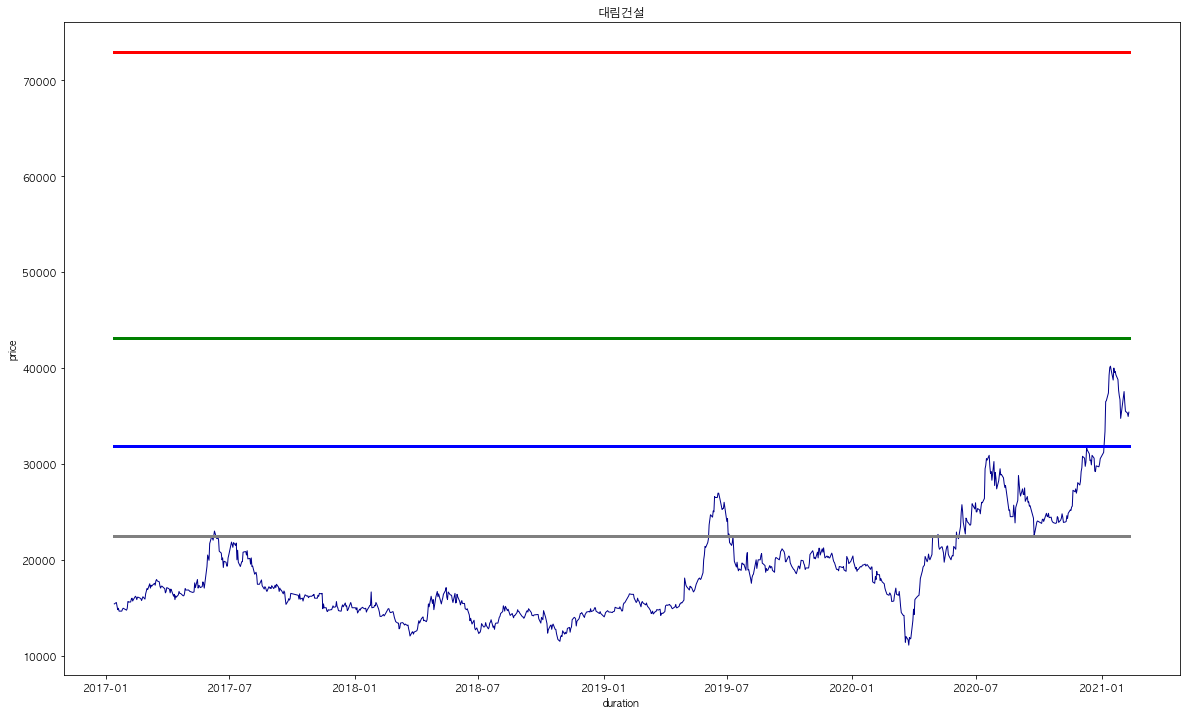

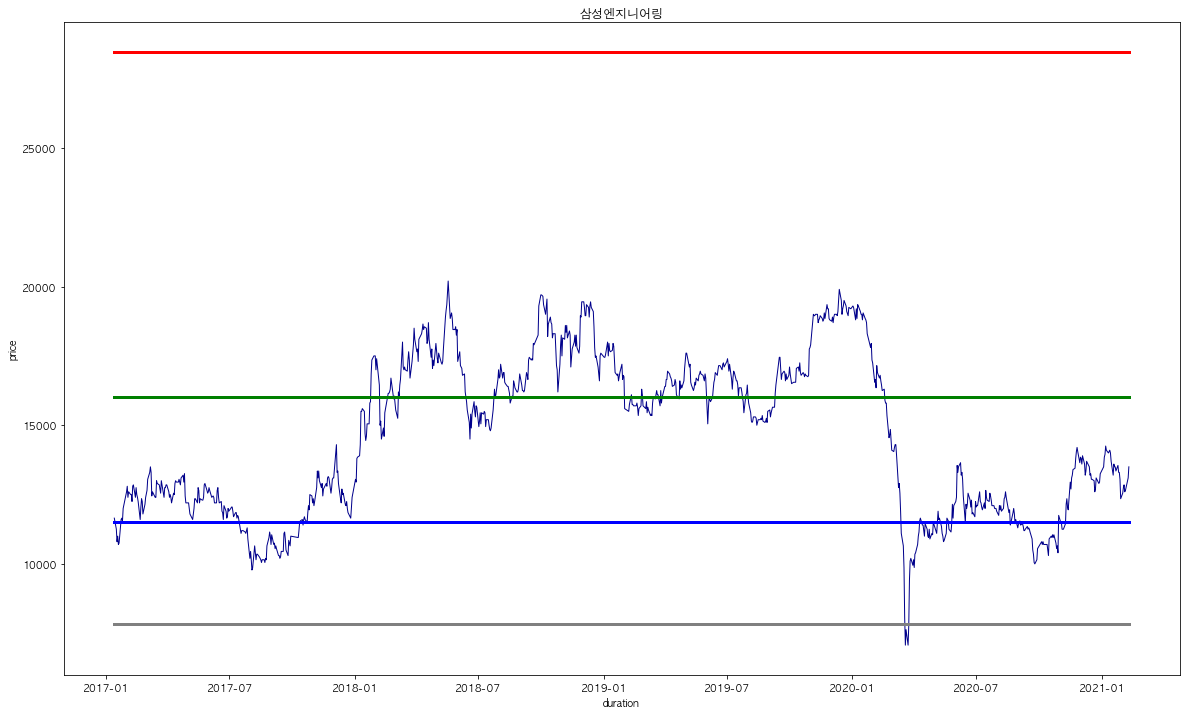

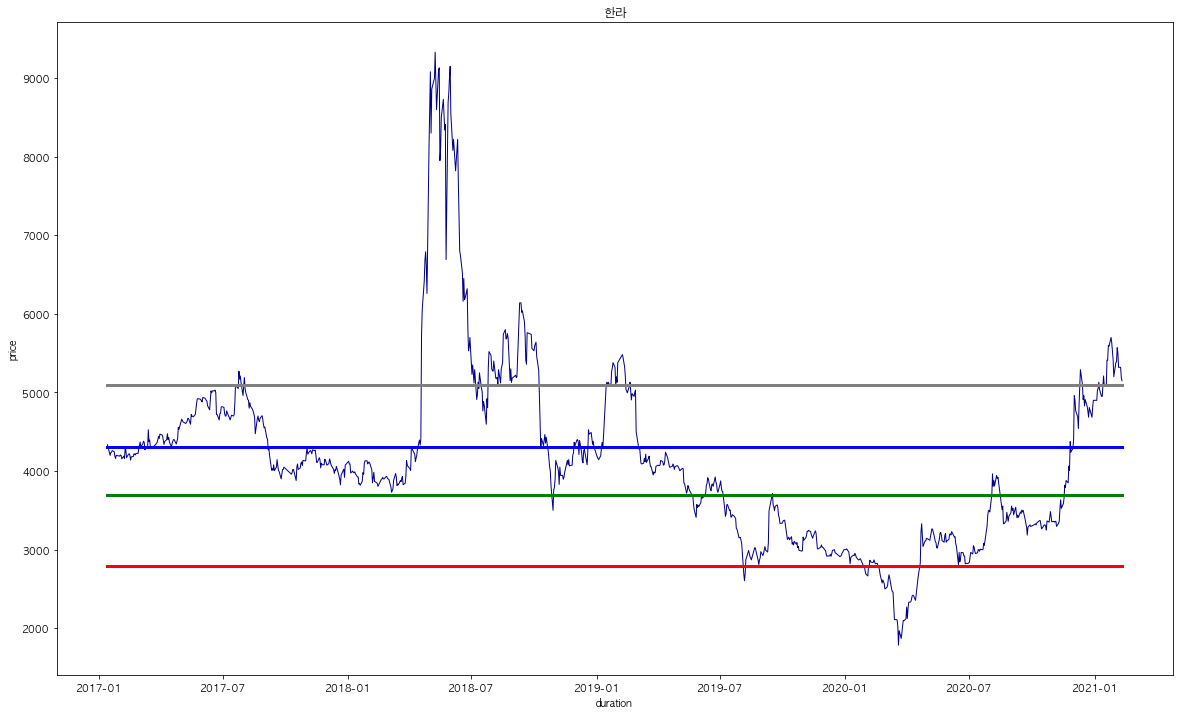

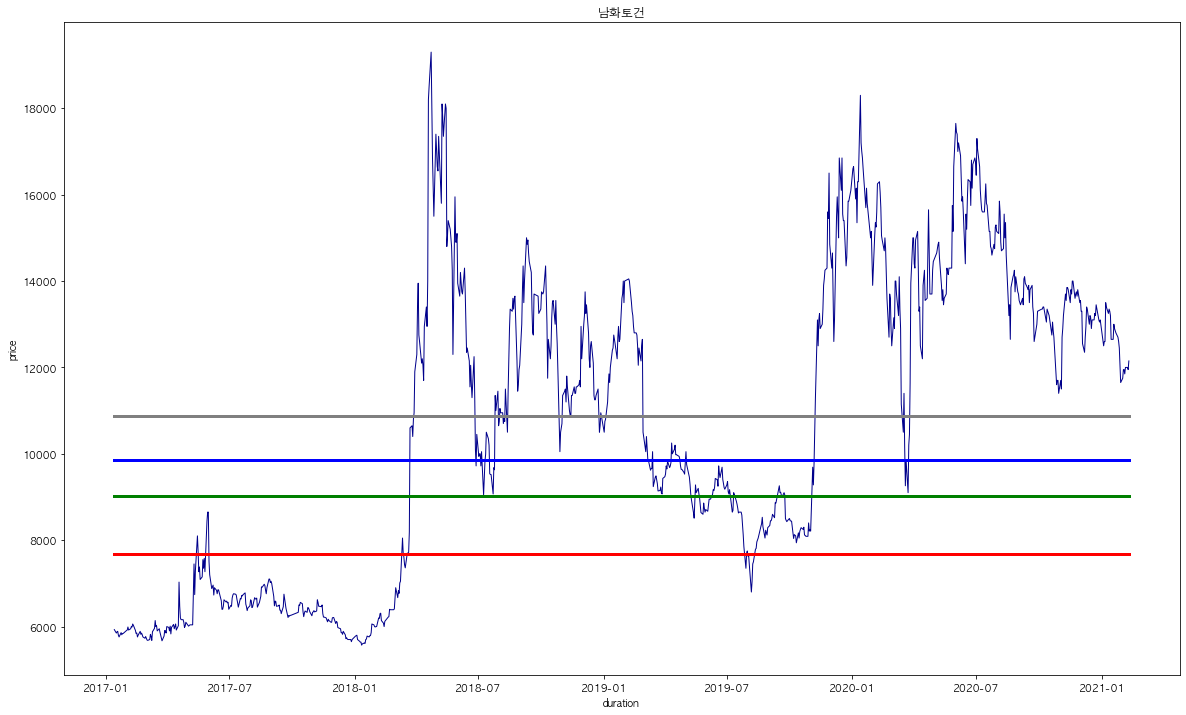

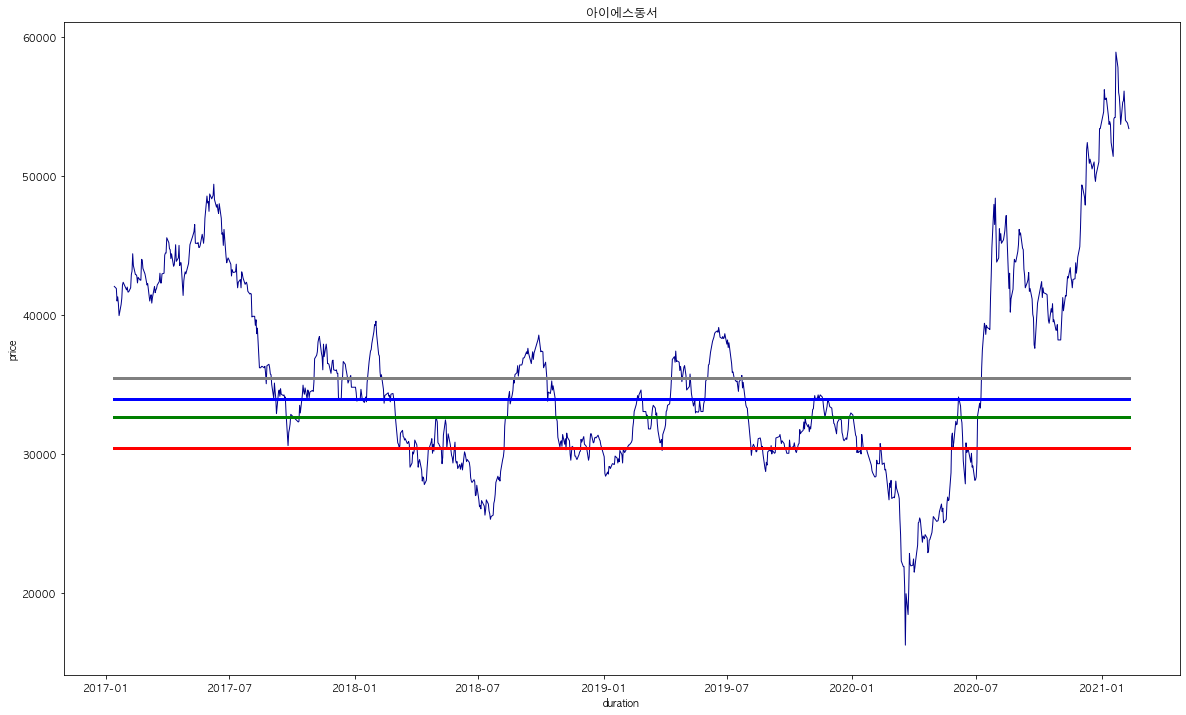

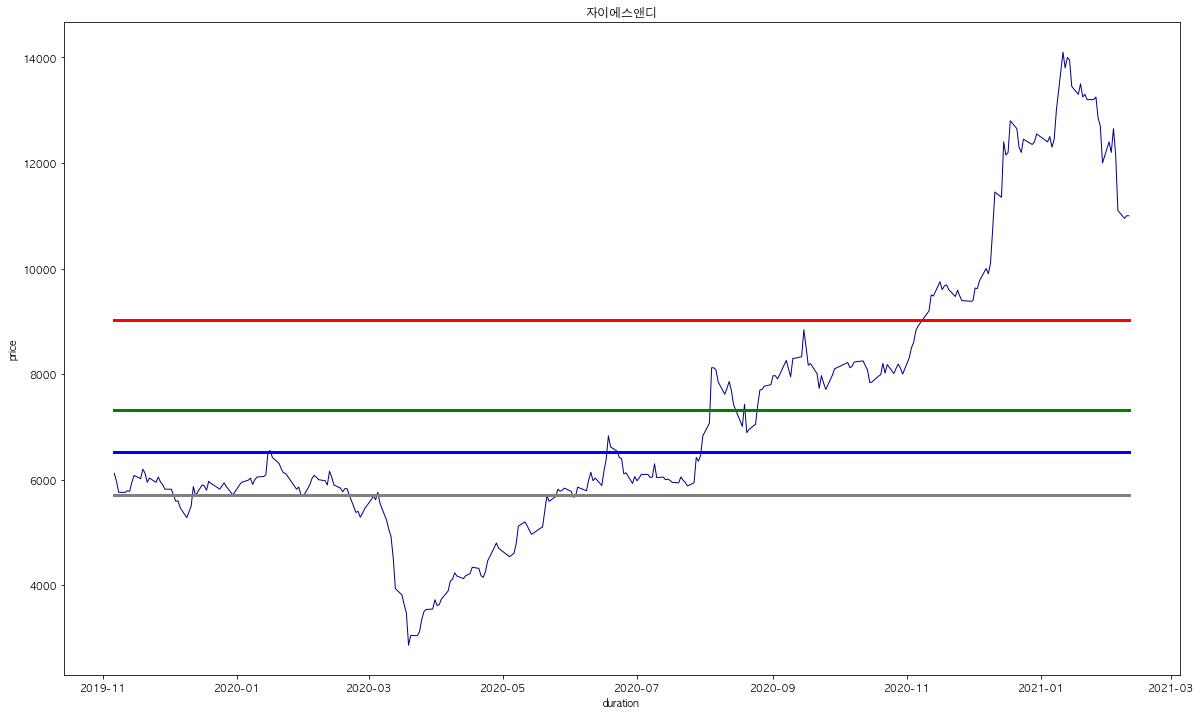

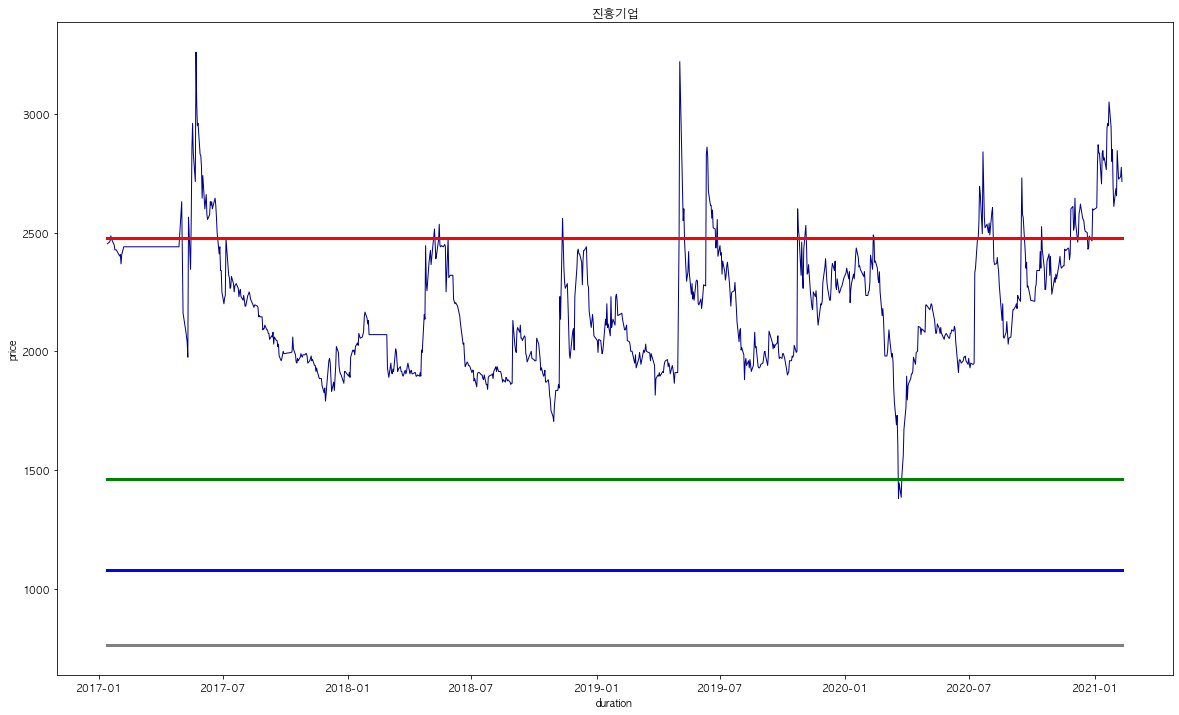

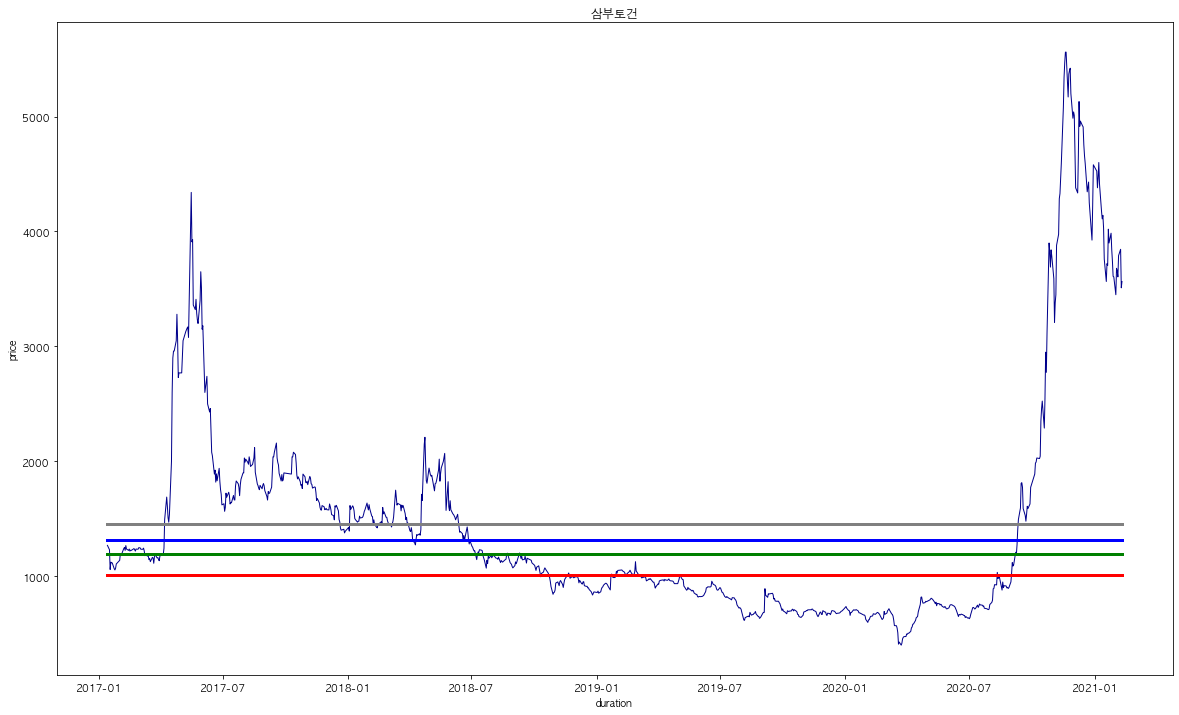

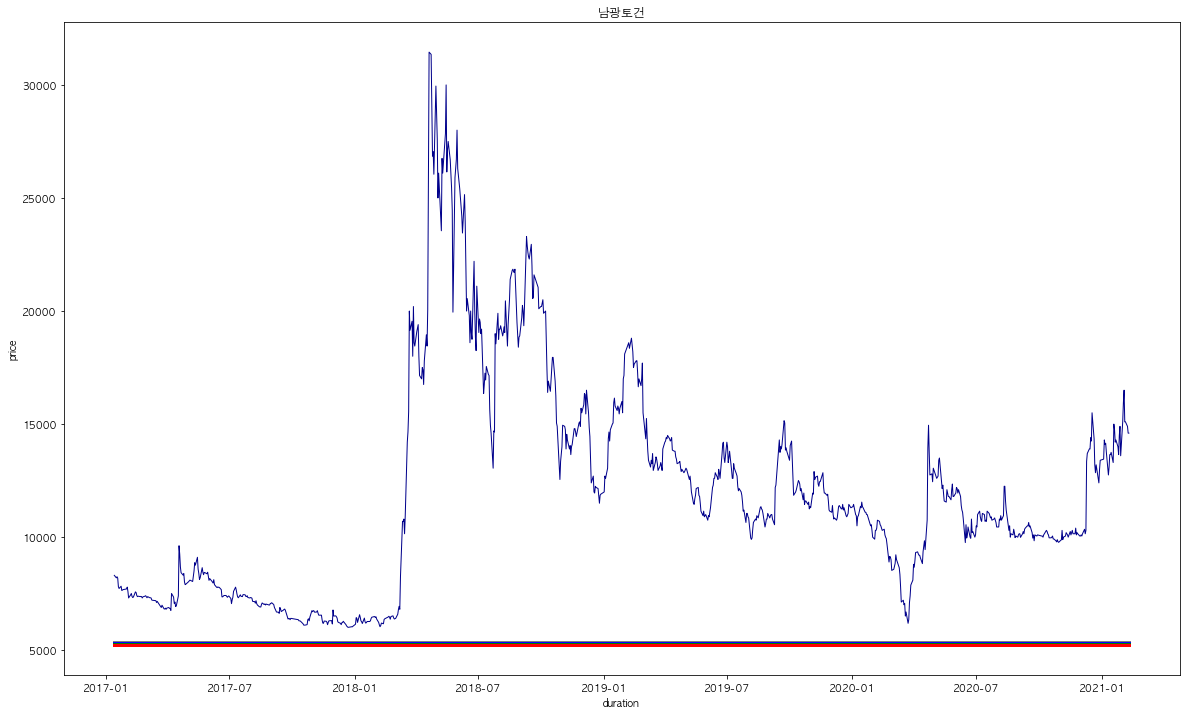

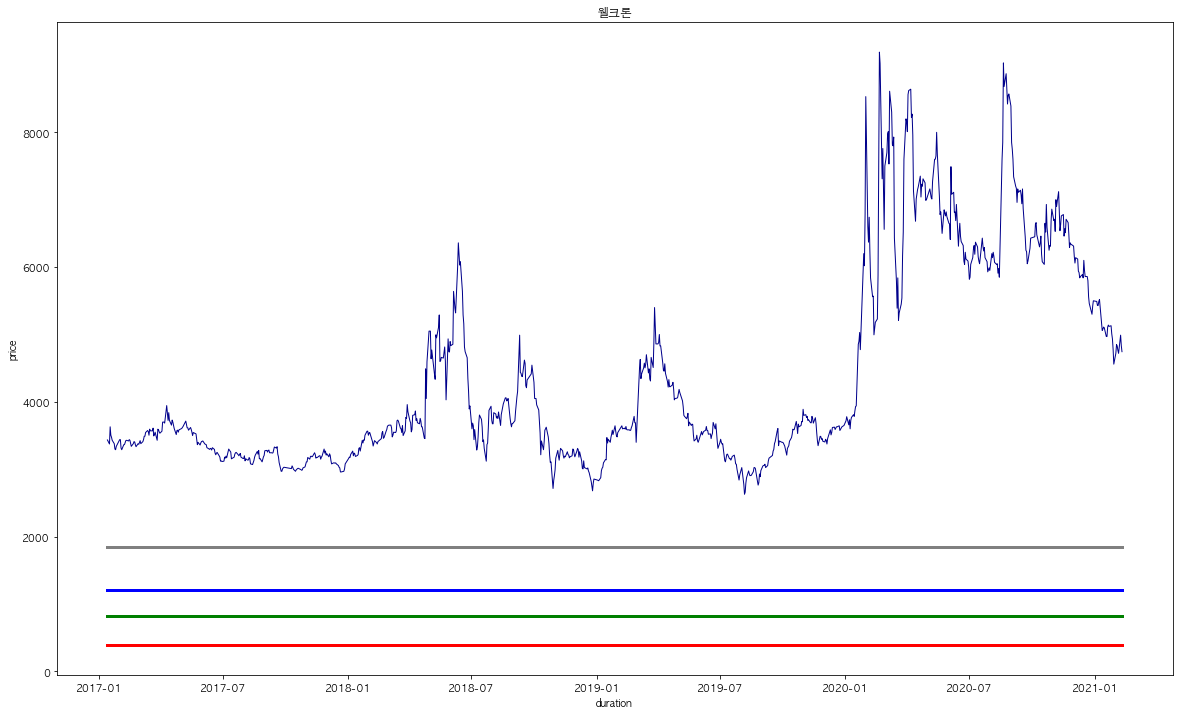

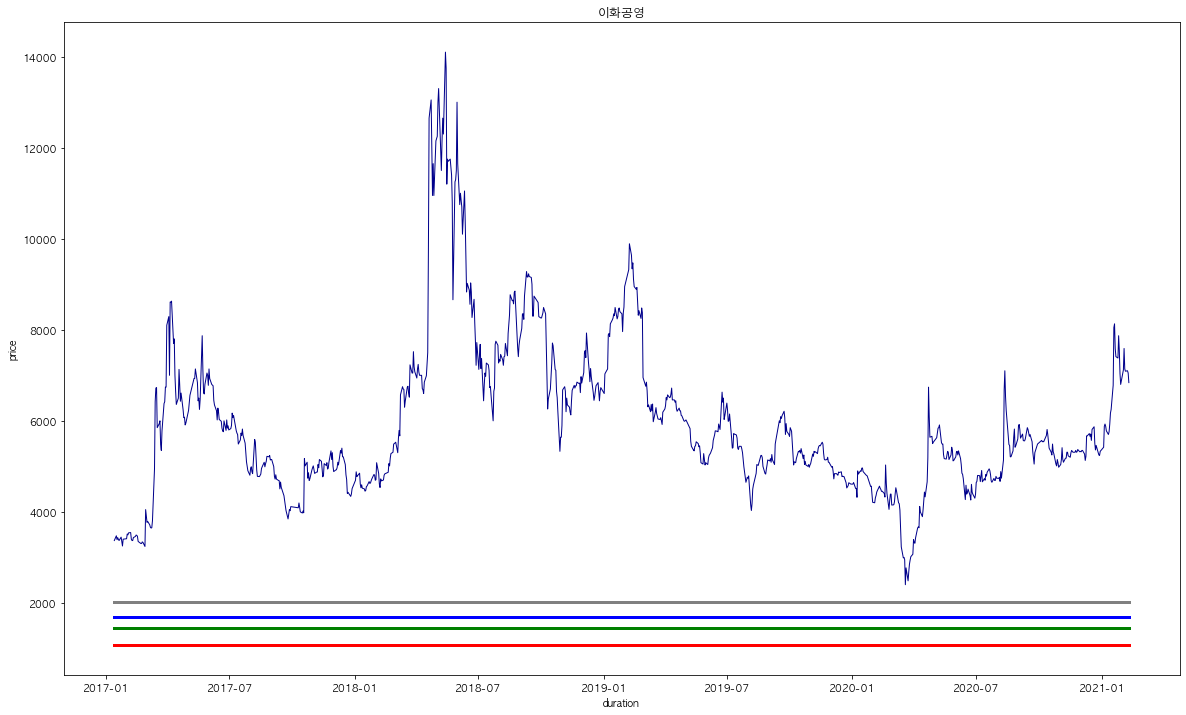

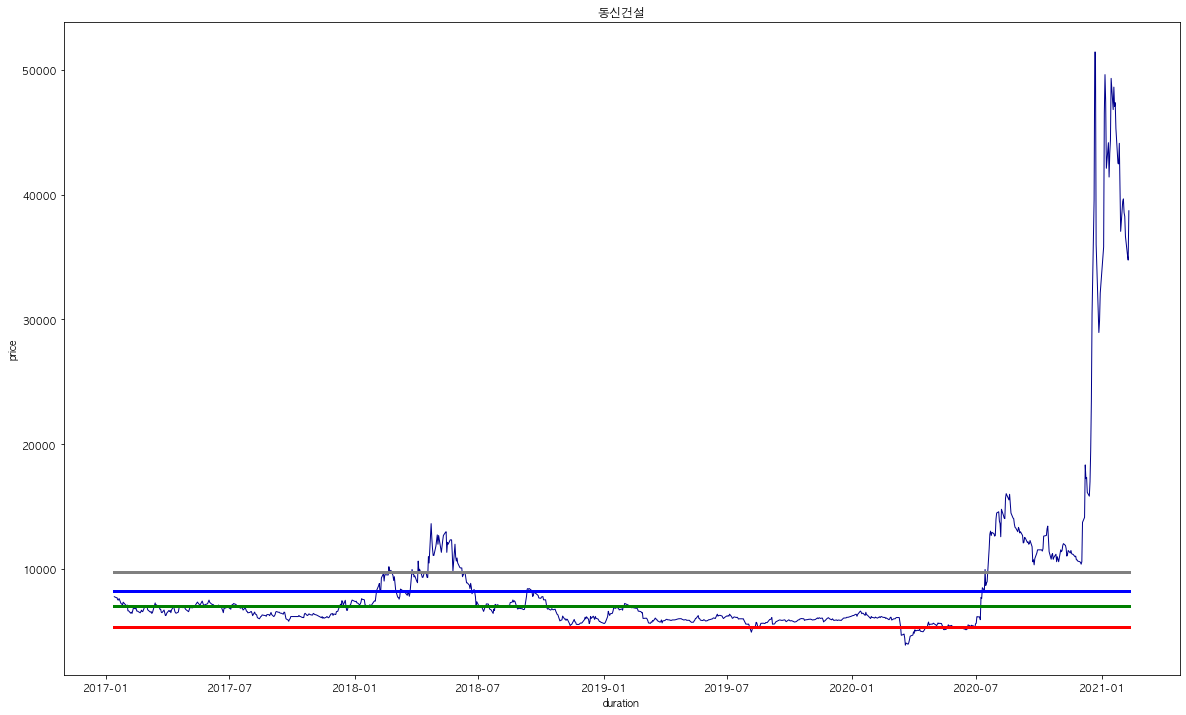

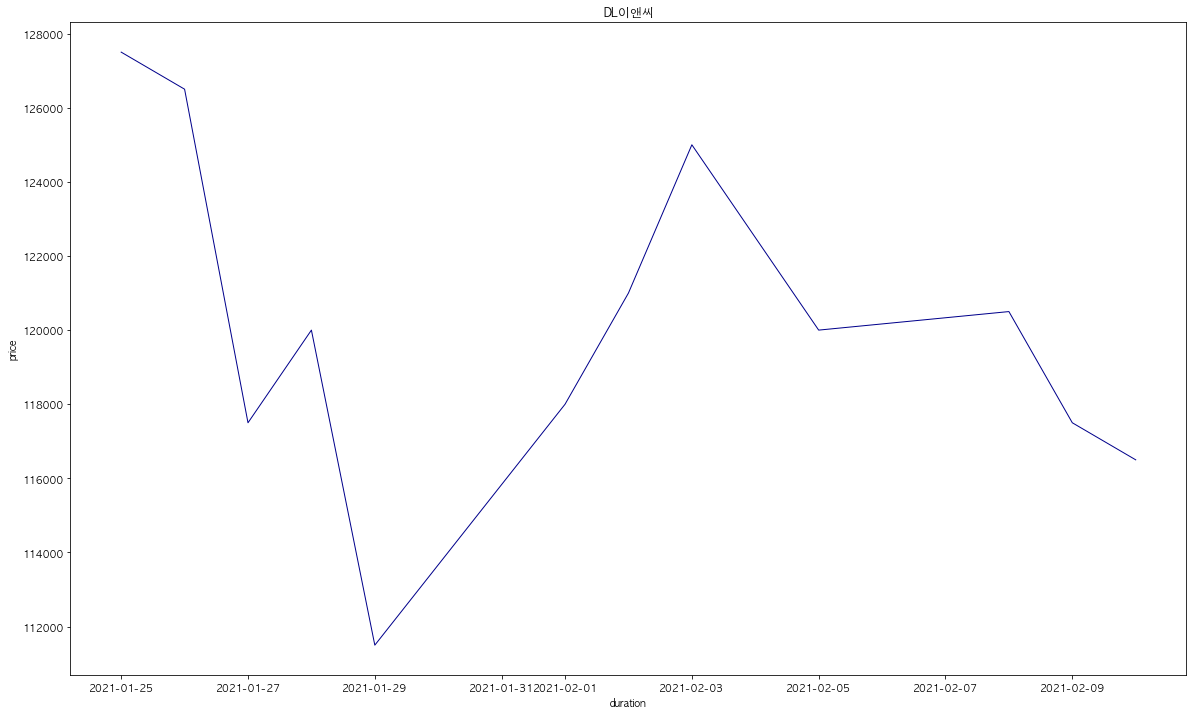

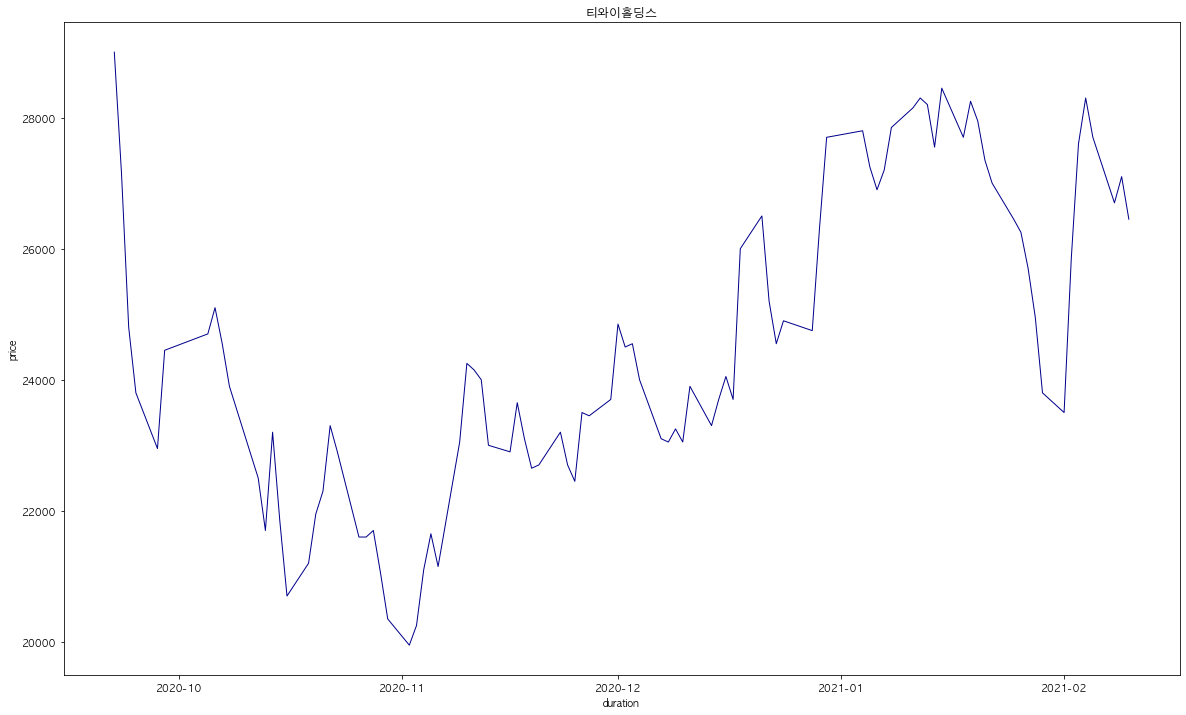

In [24]:
for company_code in company_code_list:
    company_name = nq.get_company_name(company_code, companies)

    price_df = nq.request_price_list(company_code, 'day', 1000)

    price_high = sector_df.loc[company_code]['high']
    price_middle = sector_df.loc[company_code]['middle']
    price_low = sector_df.loc[company_code]['low']
    price_very_low = sector_df.loc[company_code]['very_low']

    price_df['price_very_low'] = [price_very_low] * len(price_df)
    price_df['price_low'] = [price_low] * len(price_df)
    price_df['price_middle'] = [price_middle] * len(price_df)
    price_df['price_high'] = [price_high] * len(price_df)

    nq.show_price_chart(company_code, company_name, price_df)